## Pseudo-código Classifier

### 1° passo: recebe uma "internal workorder" que específica a quantidade, cor, tamanho, sabor e embalagem a ser produzido

In [1]:
import pandas as pd
import math
import numpy as np
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

start = time.time()

## Ler os dados fornecidos

In [55]:
RMI = pd.read_csv('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/'+'RMI_PMP.csv')
RMI.drop(columns='Unnamed: 0',inplace=True)
RMI.to_excel('RMI.xlsx')

In [2]:
path = 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/1. Base de Dados do Problema/Original/'

#Notebook Vitor: 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Base de Dados do Problema/Original/'
#Notebook Luccas: 'C:/Users/lucca/Desktop/OR & Analytics 2020/Dados/'

#IMPORTANDO E TRATANDO OS DADOS

workorder = pd.read_excel('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/Pasta sem nome/pmp_real_Detroit.xlsx')
#workorder['Color'] = workorder['Color'].str.title()
#workorder['Plant Id'] = workorder['Plant Id'].replace({'COLUMBUSOH': 'Columbus, OH', 'DETROITMI': 'Detroit, MI', 'SPRINGFIELDMO': 'Springfield, MO', 'GREENBAYWE': 'Green Bay, WE', 'OMAHANE': 'Omaha, NE'}, regex = True)
workorder['Stage'] = 0
workorder['Produzido'] = ''
workorder['Inicio'] = 0
workorder['Fim'] = 0
#
RMI = pd.read_csv('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/'+'RMI_PMP.csv')
RMI['num'] = RMI['RMI Drum'].apply(lambda x: int(x.split(sep='RMI DRUM')[-1])-1)
#
classifier_rates= pd.read_csv(path+'Classifier.csv')
classifier_rates['Site'] = classifier_rates['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
split = pd.read_csv(path+'Classifier Split.csv')
#
pfi_drum= pd.read_csv(path+'Pre-finish Inventory Drum.csv')
#
PFI = pd.read_csv(path+'Pre-finish.csv')
PFI['Site']=PFI['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
equipment = pd.read_excel(path+'Arquivos PDF/Amount of equipment and drums.xlsx', nrows = 5, index_col = 'Manufacturing Facility')
equipment['Bag Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[0]))
equipment['Box Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[2]))
equipment.drop(columns='Number of Packaging Machines', inplace = True)
#
pi_drum = pd.read_csv(path+'Pack inventory Drum.csv')
#
pounds = pd.read_csv(path+'Pound to bag and pound to box.csv', names = ['Pounds', 'Type'], index_col = 'Type')
pounds.rename(index={'lb/bag': "Bag",'lb/box': "Box",}, inplace = True)
#
packaging = pd.read_csv(path+'Packaging.csv')
packaging['Site']= packaging['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
#DEFINE A FÁBRICA DA SIMULAÇÃO
factory = workorder['Plant Id'][1]

PFI['Processing_Rate'] = PFI['Processing_Rate'].abs()
packaging['Processing_Rate'] = packaging['Processing_Rate'].abs()

custos = pd.read_csv(path + 'Custos.csv',sep = ';')
custos['Manufacturing cost by site'] = custos['Manufacturing cost by site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)

# PMP

## Análise dos dados fornecidos

In [3]:
workorder = workorder.round({'Qty': 0})
workorder.head(10)

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
0,"Detroit, MI",DM233286,Coloring Agent23,S1,F1,Bag,1522.0,0,,0,0
1,"Detroit, MI",DM233286,Coloring Agent23,S2,F1,Box,1725.0,0,,0,0
2,"Detroit, MI",DM233286,Coloring Agent23,S2,F11,Box,1505.0,0,,0,0
3,"Detroit, MI",DM233286,Coloring Agent23,S2,F12,Bag,23.0,0,,0,0
4,"Detroit, MI",DM233286,Coloring Agent23,S3,F1,Box,1550.0,0,,0,0
5,"Detroit, MI",DM233286,Coloring Agent23,S3,F1,Bag,1363.0,0,,0,0
6,"Detroit, MI",DM233286,Coloring Agent23,S5,F1,Box,1675.0,0,,0,0
7,"Detroit, MI",DM233286,Coloring Agent23,S5,F10,Bag,267.0,0,,0,0
8,"Detroit, MI",DM233286,Coloring Agent23,S5,F12,Box,552.0,0,,0,0
9,"Detroit, MI",DM233286,Coloring Agent23,S4,F1,Bag,1595.0,0,,0,0


### 2° passo: Com base na workorder recebida, vá até o RMI e pegue a quantidade "necessária" para atender o pedido. Se houver dois tambores RMI da mesma cor em um determinado local, esvazie o tambor com um número menor de equipamento.

In [4]:
RMI.drop(columns='Unnamed: 0',inplace=True)
RMI[(RMI['Location Name'] == factory)].head()

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
0,"Detroit, MI",RMI DRUM1,Coloring Agent21,246233.536,"300,000",0
1,"Detroit, MI",RMI DRUM2,Coloring Agent19,288991.000,"300,000",1
2,"Detroit, MI",RMI DRUM3,Coloring Agent16,236536.558,"300,000",2
3,"Detroit, MI",RMI DRUM4,Coloring Agent28,236048.167,"300,000",3
4,"Detroit, MI",RMI DRUM5,Coloring Agent25,300000.000,"300,000",4


#### Ao atender a workorder especificada, verifica-se que há apenas 1 drum com a cor selecionada

In [5]:
split.head()

,Color,Size,Percentage
0,Coloring Agent1,S1,12
1,Coloring Agent1,S5,27
2,Coloring Agent1,S4,19
3,Coloring Agent1,S2,29
4,Coloring Agent1,S3,13


In [6]:
Color = workorder['Color'][1] #Define a cor para obter os % dos splits
split[(split['Color ']==Color)].sort_values(by=['Size'])

,Color,Size,Percentage
114,Coloring Agent23,S1,12
110,Coloring Agent23,S2,26
113,Coloring Agent23,S3,23
111,Coloring Agent23,S4,17
112,Coloring Agent23,S5,22


### 3° passo: Processar os valores especificados no classificador e preencher os PFI Drums

In [7]:
classifier_rates

,Site,Classifier,Processing_Rate
0,"Detroit, MI",Classifier 1,3420
1,"Columbus, OH",Classifier 2,2280
2,"Green Bay, WI",Classifier 3,2050
3,"Springfield, MO",Classifier 4,1260
4,"Omaha, NE",Classifier 5,4440


In [8]:
pfi_drum[pfi_drum['Site']==factory].head()

,Site,Drum Number,Capacity In pounds
0,"Detroit, MI",PFI Drum1,"10,000"
1,"Detroit, MI",PFI Drum2,"10,000"
2,"Detroit, MI",PFI Drum3,"10,000"
3,"Detroit, MI",PFI Drum4,"10,000"
4,"Detroit, MI",PFI Drum5,"10,000"


## Pre-Finish

In [9]:
PFI[PFI['Site']==factory].head()

,Site,Size,Flavor,Processing_Rate
0,"Detroit, MI",S1,F1,1475
1,"Detroit, MI",S1,F1,1309
2,"Detroit, MI",S1,F1,1297
3,"Detroit, MI",S1,F1,1363
4,"Detroit, MI",S1,F1,1688


In [10]:
PFI['Site'].unique()

array(['Detroit, MI', 'Columbus, OH', 'Green Bay, WI', 'Springfield, MO',
       'Omaha, NE'], dtype=object)

Média de 1349.80205
Desvio padrão de 150.08233232986598


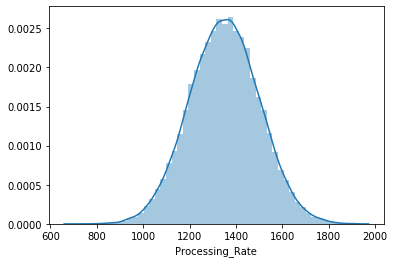

In [11]:
teste = PFI[(PFI['Site']==factory)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste)
print(f'Média de {teste.mean()}')
print(f'Desvio padrão de {teste.std()}')

In [12]:
equipment
#Temos 3 Equipamentos

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


In [13]:
pi_drum[pi_drum['Site']==factory]

,Site,Drum Number,Capacity
0,"Detroit, MI",FI Drum 1,"20,000"
1,"Detroit, MI",FI Drum 2,"20,000"
2,"Detroit, MI",FI Drum 3,"20,000"
3,"Detroit, MI",FI Drum 4,"20,000"
4,"Detroit, MI",FI Drum 5,"20,000"
5,"Detroit, MI",FI Drum 6,"20,000"
6,"Detroit, MI",FI Drum 7,"20,000"
7,"Detroit, MI",FI Drum 8,"20,000"


## Packaging

In [14]:
#Temos 2 Bags e 1 Box
#Box line tem prefência sobre Bag (SimPY)
equipment

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


Média de 2665.927
Desvio padrão de 494.0908171764816


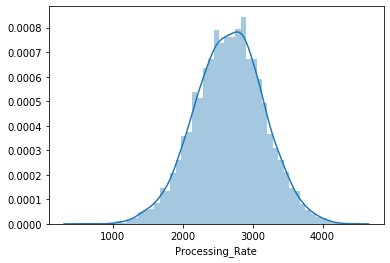

In [15]:
tipo = 'Bag' # 'Box'
teste2= packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==tipo)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste2)
print(f'Média de {teste2.mean()}')
print(f'Desvio padrão de {teste2.std()}')

In [16]:
pounds

,Pounds
Type,
Bag,0.25
Box,2.50


### Cria o DataFrame Auxiliar

In [17]:
# AUTOMATIZAR A DECLARAÇÃO DE PFI EQUIPMENTS PARA CADA FABRICA

machines = equipment[equipment.index==factory]['Number of Pre-finish operation equipment'][0]
pfi_names = []
for i in range(machines):
    pfi_names.append('PFI_'+str(i+1))

pfi_eq_aux = pd.DataFrame({'PFI': pfi_names, 'Sabor': "",'Ocupado':0 ,'Num':np.arange(machines), 'Ultimo_uso':0})
pfi_eq_aux.set_index('PFI',inplace=True)
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,,0,0,0
PFI_2,,0,1,0


In [18]:
pfi_drum_aux = pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).drop(['Site'],axis=1).astype({'Capacity In pounds': 'int32'})
pfi_drum_aux['Level'] = 0
pfi_drum_aux['Cor'] = ''
pfi_drum_aux['Size'] = ''
pfi_drum_aux['Num'] = pfi_drum_aux['Drum Number'].apply(lambda x: int(x.split('PFI_Drum')[-1])-1)
pfi_drum_aux.set_index('Drum Number',inplace=True)
pfi_drum_aux.head()

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,10000,0,,,0
PFI_Drum2,10000,0,,,1
PFI_Drum3,10000,0,,,2
PFI_Drum4,10000,0,,,3
PFI_Drum5,10000,0,,,4


In [19]:
fi_drum_aux = pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'})
fi_drum_aux['Level'] = 0
fi_drum_aux['Cor'] = ''
fi_drum_aux['Size'] = ''
fi_drum_aux['Flavor'] = ''
fi_drum_aux['Num'] = fi_drum_aux['Drum Number'].apply(lambda x: int(x.split('FI_Drum_')[-1])-1)
fi_drum_aux.set_index('Drum Number',drop=True, inplace = True)
fi_drum_aux.drop(['Site'],axis = 1, inplace = True)
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,20000,0,,,,0
FI_Drum_2,20000,0,,,,1
FI_Drum_3,20000,0,,,,2
FI_Drum_4,20000,0,,,,3
FI_Drum_5,20000,0,,,,4
FI_Drum_6,20000,0,,,,5
FI_Drum_7,20000,0,,,,6
FI_Drum_8,20000,0,,,,7


### Começo o SimPY do Classifier

In [20]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,10000,0,,,0
PFI_Drum2,10000,0,,,1
PFI_Drum3,10000,0,,,2
PFI_Drum4,10000,0,,,3
PFI_Drum5,10000,0,,,4
PFI_Drum6,10000,0,,,5
PFI_Drum7,10000,0,,,6
PFI_Drum8,10000,0,,,7
PFI_Drum9,10000,0,,,8


In [21]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,20000,0,,,,0
FI_Drum_2,20000,0,,,,1
FI_Drum_3,20000,0,,,,2
FI_Drum_4,20000,0,,,,3
FI_Drum_5,20000,0,,,,4
FI_Drum_6,20000,0,,,,5
FI_Drum_7,20000,0,,,,6
FI_Drum_8,20000,0,,,,7


In [22]:
#Para Columbus, OH

#obs: Gerenciamento da fila dos PFI Eq, Evitar SETUP
#obs: Classificador esperar só até 5...
#obs: Ordem muito grande trava tudo
#obs: lidar com decimais

box_espera = 0 #Variavel auxiliar para controle das filas
bag_espera = 0
classificador_ocupado = 0
ordens_extras = pd.DataFrame(columns = workorder.columns) #tambor-morto
ordens_complementares = pd.DataFrame(columns = workorder.columns) #quebra de ordens
ondens_sem_mp = pd.DataFrame(columns = workorder.columns)
classifier_balance = []
fim_sim = 0


def embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box):
    #new: packaging, pounds, bag, box
    global box_espera, bag_espera, fim_sim
    
    #print(f'\nEmbalador executando a ordem {ordem} em {env.now}')
    
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3]
    flavor = workorder.iloc[ordem,4]
    pack = workorder.iloc[ordem,5]
    qtd_proc = workorder.iloc[ordem,6]
    
    retirar = qtd_proc
    
    #Começo as condicionais das prefêrencias para requisitar a linha
    if len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)].index) > 0:
        
        pack_5 = workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)]['Packaging Type'].iloc[0]

        if pack == 'Box' and pack_5 == 'Box':
            #Linha está executando Box e requisita Box
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')

        elif pack == 'Box' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Box
            #print(f'Ordem {ordem} de Box esperando Bag finalizar em {env.now}')

            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Bag')].index) > 0:
                #Esperar finalizar a ordem de Bag
                box_espera = 1
                yield env.timeout(1)

            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
            box_espera = 0

        elif pack == 'Bag' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Bag
            if box_espera == 1:
                #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')

                while box_espera == 1 or len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                    #Espera que todas as box esperando sejam processadas primeiro, para depois requisitar o bag
                    bag_espera = 1
                    yield env.timeout(1)

            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0

        elif pack == 'Bag' and pack_5 == 'Box':
            #Linha está executando Box e requisita Bag
            #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')
            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                #Esperar finalizar a ordem e a fila de Box 
                bag_espera = 1
                yield env.timeout(1)
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0
        else:
            print(f'Ordem {ordem} erro 1 em {env.now}')
            
    else: #Sem sku diferente
        if pack == 'Bag':
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            
        elif pack == 'Box':
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
        else:
            print(f'Ordem {ordem} erro 2 em {env.now}')
            
    workorder.at[ordem,'Stage']=5
    #print(f'\nOrdem {ordem} mudou para o Stage 5 em {env.now}')
    
    #Calculo qual o fi_drum devo processar
    fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]

    while qtd_proc > FI_Drum[fi_drum_n].level:
        #Limpo o RMI caso o retirar seja maior do que sua nivel restante
        qtd_proc = qtd_proc-FI_Drum[fi_drum_n].level

        FI_Drum[fi_drum_n].get(FI_Drum[fi_drum_n].level)
        #print(f'Esvaziar o FI_Drum {fi_drum_n+1} para a ordem {ordem} em {env.now}')

        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''

        fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]
        #calcula qual o rmi_drum
    
    #Esvaziamos o FI Drum
    
    FI_Drum[fi_drum_n].get(qtd_proc) # max(qtd_proc,FI_Drum[fi_drum_n].level)
    
    #print(f'Ordem {ordem} Retirando {qtd_proc} do FI_Drum {fi_drum_n+1} da cor {color} e tamanho {size} e sabor {flavor}  em {env.now}\n')
        
    #Registrar que esvaziamos o PFI Drum para liberar o Classifier
    
    if FI_Drum[fi_drum_n].level ==0:
        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''
    else:
        fi_drum_aux.iat[fi_drum_n,1] = FI_Drum[fi_drum_n].level
    
    #Supondo Normalidade e sem diferença entre os tamanhos, calcula o tempo
    serie_hist = packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==pack)]['Processing_Rate'] #Série Histórica
    tempo_packging = (60*retirar/np.random.normal(serie_hist.mean(),serie_hist.std()))
     
    #Passa o tempo:    
    #print(f'\nTempo de processamento no Embalador {tempo_packging} da ordem {ordem} em {env.now}\n')
    yield env.timeout(tempo_packging)
    
    #Calcular quantas bags e box foram produzidas e finaliza o processo
    #obs: Ver como 'lidar' quando a ultima Bag ou Box for preenchida parcialmente
    
    if pack == 'Bag':
        bag_num = retirar/pounds.loc['Bag','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        #print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']= str(bag_num)+' bags'
        print(f'Ordem {ordem} produziu {bag_num} bags em {env.now}')  
        
        #Finaliza o processo
        Bag.release(req_bag)
    
    elif pack == 'Box':
        box_num = retirar/pounds.loc['Box','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']=str(box_num)+' boxes'
        #print(f'Ordem {ordem} produziu {box_num} boxes em {env.now}') 
        
        #Finaliza o processo
        Box.release(req_box)
        
    fim_sim = env.now
    
#-----------------------------------------------------------------------------------------------------------

def saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux, packaging, pounds, Bag, Box):
    
    for i in range(len(pfi_eq_aux.index)):
    #Atualizo a tabela pfi_eq_aux
        if len(PFI_Eq[i].users)>0:
            pfi_eq_aux.iat[i,1] = 1
        else:
            pfi_eq_aux.iat[i,1] = 0
            
    print(f'\nSaborizador executando a ordem {ordem} em {env.now} \n')
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3] 
    flavor = workorder.iloc[ordem,4] 
    qtd_proc = workorder.iloc[ordem,6]
    
    #Qual PFI Equipment eu vou requisitar: ---------------------
    
    if len(pfi_eq_aux[pfi_eq_aux['Ocupado']==0].index)>0: #Tenho um ou mais livres
        
        if len(pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um livre com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            #Requisito o primeiro livre
            num = pfi_eq_aux[pfi_eq_aux['Ocupado']==0].iloc[0,2]   
            
    else: #Todos ocupados
        if len(pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um ocupado com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            e_fila = []
            for e in PFI_Eq:
                e_fila.append(len(e.queue))
            num = pd.Series(e_fila).idxmin()
            #Pego o com menor fila
        
    #print(f'Ordem {ordem} Usara o PFI Equipment {num+1} em {env.now}')
    
    with PFI_Eq[num].request() as req:
        yield req
        
        sabor_old = pfi_eq_aux[pfi_eq_aux['Num']==num]['Sabor'].iloc[0]
        ultimo_uso = pfi_eq_aux[pfi_eq_aux['Num']==num]['Ultimo_uso'].iloc[0]
        
        setup = max(5-(env.now - ultimo_uso),0) #Tempo que falta para completar o SETUP
        
        if flavor != sabor_old and setup>0:
            
            #print(f'Setup de {setup} min na ordem {ordem} pois {flavor} diferente de {sabor_old} em {env.now}')
            yield env.timeout(setup)
            
        pfi_eq_aux.iat[num,0] = flavor #Recebe o sabor
        pfi_eq_aux.iat[num,3] = env.now
        
        #Calculo o PFI_Drum que devo retirar
        #OBS: RETIRAR DE MAIS DE 1 Drum quando necessário
        
        qtd = qtd_proc
        
        if qtd > pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Level'].sum():
            1==1
            #Em teoria esse if nunca deveria acontecer
            
        pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
        #print(f'Ordem {ordem} em {env.now} com pfi_drum_n {pfi_drum_n+1} e PFI_Drum[pfi_drum_n].level {PFI_Drum[pfi_drum_n].level}\n')
        
        #print(f'\nqtd {qtd} e level {PFI_Drum[pfi_drum_n].level}')
        
        while qtd > PFI_Drum[pfi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-PFI_Drum[pfi_drum_n].level

            PFI_Drum[pfi_drum_n].get(PFI_Drum[pfi_drum_n].level)
            #print(f'Esvaziar o PFI_Drum {pfi_drum_n+1} para a ordem {ordem} em {env.now}')
            
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''

            pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
            #calcula qual o pfi_drum

        #Esvaziamos o drum
        PFI_Drum[pfi_drum_n].get(qtd) #max(qtd,PFI_Drum[pfi_drum_n].level)
        #print(f'\nRetirado {qtd} do PFI_Drum {pfi_drum_n+1} da cor {color} e tamanho {size} para a ordem {ordem} em {env.now}')
        
        if PFI_Drum[pfi_drum_n].level ==0:
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''
        else:
            pfi_drum_aux.iat[pfi_drum_n,1] = PFI_Drum[pfi_drum_n].level
        
        #mudo o estado da workorder para 3 = PFI_Eq REQUISITADO
        workorder.at[ordem,'Stage']=3
        #print(f'\nOrdem {ordem} mudou para o Stage 3')
        
        serie_hist = PFI[(PFI['Site']==factory)]['Processing_Rate'] #Série Histórica
        tempo_PFI = 60*qtd_proc/np.random.normal(serie_hist.mean(),serie_hist.std())
        
        #print(f'\nTempo de processamento no Saborizador {tempo_PFI} na ordem {ordem} em {env.now}\n')
        #Passa o tempo:
        yield env.timeout(tempo_PFI)
        
        qtd_lista = []
        
        #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
        fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
        fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
        restante = fi_drum_2['restante'].sum()
        
        if restante >0:
            if restante >= qtd_proc:
                #Não precisa de novos FI Drums
                qtd_lista.append(qtd_proc)
                qtd_proc=0
            else:
                qtd_proc = qtd_proc - restante
                qtd_lista.append(restante)
        else:
            qtd_lista.append(None)
        
        while qtd_proc > FI_Drum[0].capacity:
            qtd_proc = qtd_proc - FI_Drum[0].capacity
            qtd_lista.append(FI_Drum[0].capacity)
            
        if qtd_proc >0:
            qtd_lista.append(qtd_proc)
        #Calculo quantos FI Drums eu vou precisar
        
        if len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
            #print(f'Ordem {ordem} presa no Loop do Saborizador por Falta de FI Drum em {env.now}')   
            while len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
                #Esperar até que haja 1 FI Drum Vazio
                yield env.timeout(1)
                
                qtd_lista = []
                #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
                fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
                fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
                restante = fi_drum_2['restante'].sum()

                if restante >0:
                    if restante >= qtd_proc:
                        #Não precisa de novos FI Drums
                        qtd_lista.append(qtd_proc)
                        qtd_proc=0
                    else:
                        qtd_proc = qtd_proc - restante
                        qtd_lista.append(restante)
                else:
                    qtd_lista.append(None)

                while qtd_proc > FI_Drum[0].capacity:
                    qtd_proc = qtd_proc - FI_Drum[0].capacity
                    qtd_lista.append(FI_Drum[0].capacity)

                if qtd_proc >0:
                    qtd_lista.append(qtd_proc)
        
        if qtd_lista[0] != None:
            #Preenche primeiro o FI Drum com capacidade restante
            FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
            FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]
            
            while qtd_lista[0] > (FI_Drum[FI_n].capacity - FI_Drum[FI_n].level):
                #Limpo o RMI caso o retirar seja maior do que sua nivel restante
                qtd_lista[0] = qtd_lista[0]-(FI_Drum[FI_n].capacity - FI_Drum[FI_n].level)
                
                FI_Drum[FI_n].put((FI_Drum[FI_n].capacity - FI_Drum[FI_n].level))
                #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
                
                FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
                FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]

            FI_Drum[FI_n].put(qtd_lista[0])
            #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')
            fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
            
        retirar = pd.Series(qtd_lista[1:]).sum()
        
        if retirar >0:
            #Calcula o FI Drum a ser abastecido        
            FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
            FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            while retirar > FI_Drum[FI_n].capacity:
                #Realiza a repartição do retirar
                retirar = retirar-FI_Drum[FI_n].capacity

                FI_Drum[FI_n].put(FI_Drum[FI_n].capacity)
                print(f'Preencher FI_Drum {FI_n+1} com {FI_Drum[FI_n].capacity} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Cor'] = color
                fi_drum_aux.at[FI_idx,'Size'] = size
                fi_drum_aux.at[FI_idx,'Flavor'] = flavor
                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].capacity

                FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
                FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            #print(f'Preencher FI_Drum {FI_n+1} com {retirar} para ordem {ordem}  em {env.now}\n')
            #Encho o FI_Drum
            FI_Drum[FI_n].put(retirar)

            fi_drum_aux.at[FI_idx,'Cor'] = color
            fi_drum_aux.at[FI_idx,'Size'] = size
            fi_drum_aux.at[FI_idx,'Flavor'] = flavor
            fi_drum_aux.at[FI_idx,'Level'] = retirar
        
        #Passa para o Stage 4 quem passou pelo PFI
        workorder.at[ordem,'Stage']=4
        #print(f'\nOrdem {ordem} mudou para o Stage 4 em {env.now}')

        #CHAMAR O PACKAGING
        env.process(embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box))
        
#-----------------------------------------------------------------------------------------------------------
    
def classificador (env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box):
    global ordens_extras, ordens_complementares, classificador_ocupado, classifier_balance
    
    #print(f'\nClassificador executando a ordem {ordem} em {env.now}')
    classifier_balance.append([factory, color, qtd])
    
    if qtd > 0:
        #Só ativa o Classifier se necessário
        
        qtd_time = qtd
        
        req_classifier = classifier.request()
        #Requisita o classificador somente se necessário
        yield req_classifier
        classificador_ocupado = 1

        #mudo o estado da workorder para 1 = CLASSIFICADOR REQUISITADO

        rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
        rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
        #calcula qual o rmi_drum

        while qtd > RMI_DRUM[rmi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-RMI_DRUM[rmi_drum_n].level

            RMI_DRUM[rmi_drum_n].get(RMI_DRUM[rmi_drum_n].level)
            print(f'Esvaziar o RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')

            RMI.at[rmi_drum_idx,'Color'] = ''
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0

            rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
            rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
            #calcula qual o rmi_drum

        RMI_DRUM[rmi_drum_n].get(qtd)
        #print(f'\nRetirado {qtd} do RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')
        #Retira do RMI especificado a qtd necessária

        if RMI_DRUM[rmi_drum_n].level ==0:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0
            RMI.at[rmi_drum_idx,'Color'] = ''
        else:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = RMI_DRUM[rmi_drum_n].level

        tempo_classifier = (qtd_time/classifier_rates[classifier_rates['Site']==factory].iloc[0,2])*60
        #print(f'\nTempo de processamento no Classificador {tempo_classifier} na ordem {ordem} em {env.now}\n')
        yield env.timeout(tempo_classifier)
        #Passa o tempo em minutos
        classificador_ocupado = 0
        
        divisao = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*qtd_time/100
        divisao = divisao.apply(np.floor)
        #Calcula o percentual divido de cada um dos cinco tamanhos em pounds e enche os 5 PFI Drums
        
        #Verifico a capacidade rstante de PFI Drums já preenchidos com a mesma cor
        pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
        pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
        pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']

        divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
        divisao2 = divisao2[divisao2>0]
        #Calculo quanto eu precisaria encher de cada tamanho após usar os já preenchidos
        #print(f'ordem{ordem} e divisao2 \n{divisao2}')

        divisao3 = divisao.add(-divisao2, fill_value=0)
        divisao3 = divisao3[divisao3>0]            
        #Calculo quanto eu preciso encher nos PFI Drums já preenchidos
        
        #print(f'\n{divisao3}')
                
        rest= pd.Series([])
        #print(divisao2)
        
        for i in divisao2.index:
            #Caso precise de mais de 5 tambores
            while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
        divisao2 = divisao2.append(rest)
        
        #Espera até que haja 5 ou mais PFI Drums vazios
        if len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
            
            print(f'\nOrdem {ordem} presa no Loop do Classificador por Falta de PFI Drum em {env.now}')
            #Saber se é uma morte momentanea ou definitiva
            
            usara = workorder[(workorder['Stage']==2)].copy()
            #usara são as ordens na fila da saborização

            pfi_futuro = pfi_drum_aux.copy()
            #pfi_futuro será o pfi_drum_aux após a execução das ordens na fila da saborização

            for i in usara.index:
                uso = usara.loc[i,'Qty']

                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                    uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')

                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''

                    pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')
                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''
                else:
                    pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
            #Tambores com stage faltante >=2 são mortos, pois já tiveram seus gets contabilizados no pfi_futuro. O resto é lixo (vivo)
            
            pfi_drum_2_futuro = pfi_futuro[(pfi_futuro['Cor']==color)].copy()
            pfi_drum_2_futuro['restante'] = pfi_drum_2_futuro.apply(lambda x: x['Capacity In pounds']*0.95 - x['Level'],axis=1,result_type='reduce')
            pfi_drum_2_futuro = pfi_drum_2_futuro.groupby('Size').sum()['restante']

            divisao2_futuro = divisao.add(-pfi_drum_2_futuro, fill_value=0)
            divisao2_futuro = divisao2_futuro[divisao2_futuro>0]

            divisao3_futuro = divisao.add(-divisao2_futuro, fill_value=0)
            divisao3_futuro = divisao3_futuro[divisao3_futuro>0]

            rest= pd.Series([])
            for i in divisao2_futuro.index:
                #Caso precise de mais de 5 tambores
                while divisao2_futuro[i] > 0.95*PFI_Drum[0].capacity:
                    divisao2_futuro[i] = divisao2_futuro[i] - 0.95*PFI_Drum[0].capacity
                    rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
            divisao2_futuro = divisao2_futuro.append(rest)
                
            if len(divisao2_futuro) <= len(pfi_futuro[pfi_futuro.Level==0].index):
                print(f'\nMorte momentanea na ordem {ordem} em {env.now}')
            
            else:
                preciso_liberar = len(divisao2_futuro) - len(pfi_futuro[pfi_futuro.Level==0].index) #Target
                print(f'\nMorte definitiva na ordem {ordem} em {env.now} que precisa liberar {preciso_liberar} pfi drums')
            
                #Criar uma ordem para esvaziar esses tambores
                tambores_mortos = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante']>=2)].iloc[:preciso_liberar]
                
                workorder_fantasma = pd.DataFrame(data={'Color':tambores_mortos['Cor'], 'Size':tambores_mortos['Size'], 'Qty':tambores_mortos['Level'], 'Plant Id':factory, 'Flavor': workorder.iloc[ordem,4],'Packaging Type':'Bag', 'Stage':2},columns = workorder.columns)
                ordem_fantasma = np.arange(len(tambores_mortos.index)) + len(workorder.index)
                workorder_fantasma.index = ordem_fantasma
                print(f'\n workorder_fantasma para ordem {ordem} em {env.now} \n{workorder_fantasma}')

                ordens_extras = ordens_extras.append(workorder_fantasma)

                for i in ordem_fantasma:
                    #Envio as ordens fantasmas
                    workorder.loc[i] = list(workorder_fantasma.loc[i])
                    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, i, fi_drum_aux, packaging, pounds, Bag, Box))
            
            while len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
                #Durante esse tempo alguns PFI Drums contendo a mesma cor parcialemente cheios podem ter capacidade 'liberada'
                yield env.timeout(1)
                
                pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
                pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
                pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']
                
                #print(f'ordem {ordem} em {env.now}\n e \n{pfi_drum_aux}') #TINHA 5 restante

                divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
                divisao2 = divisao2[divisao2>0]

                divisao3 = divisao.add(-divisao2, fill_value=0)
                divisao3 = divisao3[divisao3>0]
                
                rest= pd.Series([])
                #print(divisao2)

                for i in divisao2.index:
                    #Caso precise de mais de 5 tambores
                    while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                        divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                        rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
                divisao2 = divisao2.append(rest)            
              
        for z in range(len(divisao3)):
            
            parcial = math.floor(divisao3[z])
            
            try:
                pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color)& (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
            except:
                pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]
            
            while parcial > (PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level):
                #Realiza a repartição do parcial
                parcial = parcial-(PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level)

                PFI_Drum[pfi_n].put((PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level))
                pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].capacity*0.95
                pfi_drum_aux.at[pfi_idx, 'Cor']= color
                pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
                
                try:
                    pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                    pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
                except:
                    pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                    pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]

            PFI_Drum[pfi_n].put(parcial)
            pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].level
            pfi_drum_aux.at[pfi_idx, 'Cor']= color
            pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
        
        #print(f'ordem {ordem} em {env.now} com divisao2 \n{divisao2}')

        for x in range(len(divisao2)):
            PFI_Drum[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[x,4]].put(math.floor(divisao2[x]))
            #Preencher primeiro o PFI Drum de menor número (mais vazio) -- FEITO
            
        for y in range(len(divisao2)): 
            #Alimento a planilha auxiliar
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Cor']= color
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Size']= list(divisao2.index)[y]
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Level']= math.floor(divisao2[y])
        
        classifier.release(req_classifier)
        #Libera o Classifier
        
    else:
        1==1
        #print(f'\nOrdem {ordem} já possuia classificado o que precisava em {env.now}')
        
    #mudo o estado da workorder para 2 = PFI DRUM PREENCHIDO
    workorder.at[ordem,'Stage']=2
    print(f'\nOrdem {ordem} mudou para o Stage 2 em {env.now}')

    #CHAMAR O PI OPERATION
    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux,packaging, pounds, Bag, Box))

#-----------------------------------------------------------------------------------------------------------
            
# Função executora de Workorders
def workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box):
    global ondens_sem_mp
    for ordem in workorder.index:
        #Pula a ordem se não houver a cor
        
        while len(workorder[workorder['Stage']==1]) > 0:
            #Espera o classificador ser liberado
            yield env.timeout(1)
            
        workorder.at[ordem,'Stage']=0
        #Mudaria o Stage da primeira workorder

        color = workorder.iloc[ordem,2]
        size = workorder.iloc[ordem,3]
        qtd_proc = workorder.iloc[ordem,6] #2 Casas decimais

        #Verifico o que já tenho classificado dessa cor e tamanho
        qtd_classificado = pfi_drum_aux[(pfi_drum_aux['Cor'] == color) & (pfi_drum_aux['Size'] == size)]['Level'].sum()

        qtd_a_ser_usado = workorder[(workorder['Stage']==2) & (workorder['Color']== color) & (workorder['Size']== size)]['Qty'].sum()
        #Podem ter ordens no Stage 2 que foram classificadas mais ainda não fizeram o seus gets dos PFIs

        liberado = qtd_classificado - qtd_a_ser_usado

        if liberado >0:
            #Calculo apenas o necessario para complementar o que já tenho
            qtd_proc = max(qtd_proc - liberado,0)

        qtd = math.ceil(qtd_proc/(split[(split['Color ']== color) & (split['Size']== size)].iloc[0,2]/100))
        #calcula a quantidade a ser retirada do RMI (SOMENTE O NECESSÁRIO)

        disponivel = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color)]['Qty in pounds'].sum()

        if disponivel >= qtd:
            
            env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box))

            workorder.at[ordem,'Stage']=1
            workorder.at[ordem,'Inicio']=env.now
            #print(f'\nOrdem {ordem} mudou para o Stage 1 em {env.now}\nE pegará {qtd} da cor {color} na fabrica {factory} que disponivel {disponivel}')

        elif disponivel>0:
            #Gerar ordem incompleta:
            posso_clas = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*disponivel/100
            posso_clas = posso_clas.apply(np.floor)

            falta_proc = qtd_proc - posso_clas[size]
            workorder_complementar = workorder.loc[ordem].copy()

            workorder.at[ordem,'Stage']= 1
            workorder.at[ordem,'Inicio']= env.now
            workorder.at[ordem,'Qty'] = posso_clas[size] + liberado
            env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, disponivel, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box))
            #print(f'\nOrdem {ordem} foi quebrada com {posso_clas[size] + liberado} e mudou para o Stage 1 em {env.now} e o disponivel {disponivel}')

            workorder_complementar.at['Qty'] = falta_proc
            ordem_complementar = len(workorder.index)
            workorder_complementar.at['Stage'] = 99
            workorder.loc[ordem_complementar] = workorder_complementar
            #adiciono ela no pmp_mae
            ondens_sem_mp = ondens_sem_mp.append(workorder_complementar,sort=False)
        else:
            #print(f'\nOrdem {ordem} não atendida pois necessita {qtd} e há disponivel {disponivel} da cor {color} na fabrica {factory} em {env.now}')
            workorder.at[ordem,'Stage']=99
            ondens_sem_mp = ondens_sem_mp.append(workorder.iloc[ordem],sort=False)
            
        yield env.timeout(1)
            
tamanho_da_fila_clas = []
tamanho_da_fila_pfi = []
tamanho_da_fila_bag = []
tamanho_da_fila_box = []

ociosidade_classifier = []
ociosidade_saborizador = []
ociosidade_embalador_Box=[]
ociosidade_embalador_Bag=[]
#-----------------------------------------------------------------------------------------------------------

# Função observadora do processo
def observador(env, classifier, PFI_Eq, Bag, Box):
    while True:
        tamanho_da_fila_clas.append(len(classifier.queue)) #Não me diz muito
        ociosidade_classifier.append(classificador_ocupado)
        
        lista = []
        lista2 = []
        for i in range(len(PFI_Eq)):
            lista.append(len(PFI_Eq[i].queue))
            lista2.append(PFI_Eq[i].count)
            
        tamanho_da_fila_pfi.append(lista)
        ociosidade_saborizador.append(lista2)
        
        
        tamanho_da_fila_bag.append(len(Bag.queue)+bag_espera)
        tamanho_da_fila_box.append(len(Box.queue)+box_espera)
        ociosidade_embalador_Box.append(Box.count)
        ociosidade_embalador_Bag.append(Bag.count)
        
        yield env.timeout(1)

In [23]:
env = simpy.Environment()

#DECLARO OS PFI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
PFI_Drum = []
a = dict(pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).set_index('Drum Number').astype({'Capacity In pounds': 'int32'})['Capacity In pounds'])
for key,val in a.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('PFI_Drum.append(' + key+')')

#DECLARO OS PI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
FI_Drum = []
b = dict(pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('Drum Number')['Capacity'])
for key,val in b.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('FI_Drum.append(' + key+')')

#DECLARO OS RMI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
RMI_DRUM = []
c = RMI[RMI['Location Name']==factory].replace({'RMI Drum': ' ', 'Capacity':','}, {'RMI Drum': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('RMI Drum')[['Qty in pounds','Capacity']].to_dict('index')
for key in c.keys():
    val = c[key]['Qty in pounds']
    val2 = c[key]['Capacity']
    exec(key + '= simpy.Container(env, capacity = val2, init=val)')
    exec('RMI_DRUM.append(' + key+')')

#Declaro o Classifier
classifier = simpy.Resource(env, capacity=1)

#Declaro os PI Equipments ITERATIVAMENTE
PFI_Eq = []
for key in range(equipment[equipment.index==factory]['Number of Pre-finish operation equipment'].iloc[0]):
    exec('PFI_'+str(key)+' = simpy.Resource(env, capacity = 1)')
    exec('PFI_Eq.append(PFI_'+str(key)+')')

#Declarar os Packaging:

Bag = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Bag Machines'].iloc[0])
Box = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Box Machines'].iloc[0])

In [77]:
262620/(24*60)

182.375

In [24]:
env.process(workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box))
env.process(observador(env, classifier, PFI_Eq, Bag, Box))
env.run(until=300000) #262620


Ordem 0 mudou para o Stage 2 em 222.52631578947367

Saborizador executando a ordem 0 em 222.52631578947367 


Ordem 1 mudou para o Stage 2 em 223

Saborizador executando a ordem 1 em 223 


Ordem 2 mudou para o Stage 2 em 224

Saborizador executando a ordem 2 em 224 


Ordem 3 mudou para o Stage 2 em 225

Saborizador executando a ordem 3 em 225 


Ordem 4 mudou para o Stage 2 em 226

Saborizador executando a ordem 4 em 226 


Ordem 5 mudou para o Stage 2 em 227

Saborizador executando a ordem 5 em 227 


Ordem 6 mudou para o Stage 2 em 228

Saborizador executando a ordem 6 em 228 


Ordem 7 mudou para o Stage 2 em 229

Saborizador executando a ordem 7 em 229 


Ordem 8 mudou para o Stage 2 em 230

Saborizador executando a ordem 8 em 230 


Ordem 9 mudou para o Stage 2 em 231

Saborizador executando a ordem 9 em 231 


Ordem 10 mudou para o Stage 2 em 232

Saborizador executando a ordem 10 em 232 


Ordem 11 mudou para o Stage 2 em 233

Saborizador executando a ordem 11 em 233 

Ordem 

C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



Ordem 14 mudou para o Stage 2 em 463

Saborizador executando a ordem 14 em 463 


Ordem 15 mudou para o Stage 2 em 464

Saborizador executando a ordem 15 em 464 


Ordem 16 mudou para o Stage 2 em 465

Saborizador executando a ordem 16 em 465 


Ordem 17 mudou para o Stage 2 em 466

Saborizador executando a ordem 17 em 466 


Ordem 18 mudou para o Stage 2 em 467

Saborizador executando a ordem 18 em 467 


Ordem 19 mudou para o Stage 2 em 468

Saborizador executando a ordem 19 em 468 


Ordem 20 mudou para o Stage 2 em 469

Saborizador executando a ordem 20 em 469 

Ordem 5 produziu 5452.0 bags em 532.8469270662574
Ordem 12 produziu 6220.0 bags em 567.0177432721713
Ordem 14 produziu 3040.0 bags em 588.1597410360712

Ordem 6 mudou para o Stage 6 em 598.4551646656957
Ordem 16 produziu 1788.0 bags em 600.43805048072
Ordem 17 produziu 2872.0 bags em 631.3958731033796

Ordem 21 mudou para o Stage 2 em 669.1228070175439

Saborizador executando a ordem 21 em 669.1228070175439 


Ordem 22 mud

Ordem 63 produziu 6352.0 bags em 2371.4593319088644
Ordem 62 produziu 5672.0 bags em 2406.548478955112
Ordem 65 produziu 6320.0 bags em 2451.472367970817
Ordem 64 produziu 6888.0 bags em 2490.2035885827186
Ordem 67 produziu 5704.0 bags em 2525.457017225032

Ordem 66 mudou para o Stage 6 em 2538.511442373265
Ordem 68 produziu 5692.0 bags em 2575.3013538205873

Ordem 84 mudou para o Stage 2 em 2575.6315789473683

Saborizador executando a ordem 84 em 2575.6315789473683 


Ordem 85 mudou para o Stage 2 em 2576

Saborizador executando a ordem 85 em 2576 


Ordem 86 mudou para o Stage 2 em 2577

Saborizador executando a ordem 86 em 2577 


Ordem 87 mudou para o Stage 2 em 2578

Saborizador executando a ordem 87 em 2578 


Ordem 88 mudou para o Stage 2 em 2579

Saborizador executando a ordem 88 em 2579 

Ordem 69 produziu 6792.0 bags em 2613.8565902951823

Ordem 70 mudou para o Stage 6 em 2641.648503425654

Ordem 71 mudou para o Stage 6 em 2704.5298499184323
Ordem 73 produziu 7936.0 bags em 2


Ordem 148 mudou para o Stage 2 em 7308.263157894737

Saborizador executando a ordem 148 em 7308.263157894737 


Ordem 149 mudou para o Stage 2 em 7309

Saborizador executando a ordem 149 em 7309 


Ordem 150 mudou para o Stage 2 em 7310

Saborizador executando a ordem 150 em 7310 


Ordem 151 mudou para o Stage 2 em 7311

Saborizador executando a ordem 151 em 7311 


Ordem 152 mudou para o Stage 2 em 7312

Saborizador executando a ordem 152 em 7312 


Ordem 153 mudou para o Stage 2 em 7501.596491228071

Saborizador executando a ordem 153 em 7501.596491228071 


Ordem 154 mudou para o Stage 2 em 7502

Saborizador executando a ordem 154 em 7502 


Ordem 155 mudou para o Stage 2 em 7503

Saborizador executando a ordem 155 em 7503 


Ordem 156 mudou para o Stage 2 em 7504

Saborizador executando a ordem 156 em 7504 


Ordem 157 mudou para o Stage 2 em 7505

Saborizador executando a ordem 157 em 7505 

Ordem 119 produziu 38000.0 bags em 7508.144491360213

Ordem 158 mudou para o Stage 2 em 


Ordem 166 mudou para o Stage 6 em 9339.422193191764
Ordem 142 produziu 6932.0 bags em 9345.729562189383
Ordem 168 produziu 4616.0 bags em 9392.976042229866
Ordem 144 produziu 5588.0 bags em 9433.683074274748

Ordem 170 mudou para o Stage 6 em 9468.249116978785
Ordem 146 produziu 6856.0 bags em 9487.86803858589

Ordem 223 presa no Loop do Classificador por Falta de PFI Drum em 9497.456140350878

Morte momentanea na ordem 223 em 9497.456140350878

Ordem 172 mudou para o Stage 6 em 9540.84597368162
Ordem 149 produziu 6844.0 bags em 9562.749282154453
Ordem 174 produziu 4228.0 bags em 9588.592875079585
Ordem 151 produziu 5320.0 bags em 9617.22956743637

Ordem 176 mudou para o Stage 6 em 9643.169152272892
Ordem 178 produziu 5168.0 bags em 9713.817679563937
Ordem 154 produziu 7844.0 bags em 9753.78014936598
Ordem 179 produziu 4348.0 bags em 9771.836535642384
Ordem 157 produziu 7120.0 bags em 9810.764156076006

Ordem 223 mudou para o Stage 2 em 9818.456140350878

Saborizador executando a orde


Ordem 226 mudou para o Stage 6 em 11773.83506682367
Ordem 230 produziu 5948.0 bags em 11800.82532356555

Ordem 228 mudou para o Stage 6 em 11850.25984871158

Ordem 266 presa no Loop do Classificador por Falta de PFI Drum em 11856.491228070176

Morte momentanea na ordem 266 em 11856.491228070176
Ordem 232 produziu 6144.0 bags em 11883.488478770967

Ordem 266 mudou para o Stage 2 em 11898.491228070176

Saborizador executando a ordem 266 em 11898.491228070176 


Ordem 267 mudou para o Stage 2 em 11899.009403508773

Saborizador executando a ordem 267 em 11899.009403508773 


Ordem 234 mudou para o Stage 6 em 11949.652745943891
Ordem 229 produziu 7180.0 bags em 11951.366189882481
Ordem 231 produziu 6448.0 bags em 11994.80497155474
Ordem 236 produziu 5468.0 bags em 12031.48415139941
Ordem 233 produziu 5496.0 bags em 12060.95541544345
Ordem 238 produziu 7304.0 bags em 12121.891072624298
Ordem 235 produziu 5948.0 bags em 12153.916674130836

Ordem 271 presa no Loop do Classificador por Falta d


Ordem 288 mudou para o Stage 6 em 14481.237657241092
Ordem 289 produziu 7264.0 bags em 14522.725330055762
Ordem 290 produziu 5684.0 bags em 14553.322779333017
Ordem 291 produziu 5356.0 bags em 14591.197871549099
Ordem 292 produziu 6504.0 bags em 14631.334117139211
Ordem 293 produziu 6852.0 bags em 14677.265315827335

Ordem 297 mudou para o Stage 6 em 14692.017058993197
Ordem 294 produziu 6044.0 bags em 14713.493669636528

Ordem 298 mudou para o Stage 6 em 14756.083322533586

Ordem 329 presa no Loop do Classificador por Falta de PFI Drum em 14773.122807017544

Morte momentanea na ordem 329 em 14773.122807017544
Ordem 295 produziu 5940.0 bags em 14789.927631264069
Ordem 301 produziu 5776.0 bags em 14824.459179590865

Ordem 329 mudou para o Stage 2 em 14835.122807017544

Saborizador executando a ordem 329 em 14835.122807017544 


Ordem 330 mudou para o Stage 2 em 14836

Saborizador executando a ordem 330 em 14836 


Ordem 331 mudou para o Stage 2 em 14837

Saborizador executando a ordem 


Ordem 369 mudou para o Stage 2 em 18336.736842105263

Saborizador executando a ordem 369 em 18336.736842105263 


Ordem 370 mudou para o Stage 2 em 18337

Saborizador executando a ordem 370 em 18337 


Ordem 371 mudou para o Stage 2 em 18338

Saborizador executando a ordem 371 em 18338 


Ordem 372 mudou para o Stage 2 em 18339

Saborizador executando a ordem 372 em 18339 


Ordem 373 mudou para o Stage 2 em 18340

Saborizador executando a ordem 373 em 18340 


Ordem 374 mudou para o Stage 2 em 18341

Saborizador executando a ordem 374 em 18341 


Ordem 375 mudou para o Stage 2 em 18342

Saborizador executando a ordem 375 em 18342 


Ordem 376 mudou para o Stage 2 em 18343

Saborizador executando a ordem 376 em 18343 


Ordem 377 mudou para o Stage 2 em 18344

Saborizador executando a ordem 377 em 18344 


Ordem 378 mudou para o Stage 2 em 18345

Saborizador executando a ordem 378 em 18345 


Ordem 379 mudou para o Stage 2 em 18346

Saborizador executando a ordem 379 em 18346 

Ordem 

Ordem 432 mudou para o Stage 2 em 20079

Saborizador executando a ordem 432 em 20079 


Ordem 433 mudou para o Stage 2 em 20080

Saborizador executando a ordem 433 em 20080 


Ordem 409 mudou para o Stage 6 em 20097.229093131842
Ordem 407 produziu 8072.0 bags em 20104.279002182113
Ordem 410 produziu 6440.0 bags em 20154.240655397247
Ordem 411 produziu 5132.0 bags em 20179.60455379835
Ordem 412 produziu 7372.0 bags em 20220.5019972392
Ordem 413 produziu 6880.0 bags em 20262.714368348872
Ordem 414 produziu 7160.0 bags em 20314.475819166488

Ordem 434 presa no Loop do Classificador por Falta de PFI Drum em 20318.333333333332

Morte momentanea na ordem 434 em 20318.333333333332
Ordem 415 produziu 7388.0 bags em 20350.248439928622
Ordem 416 produziu 6528.0 bags em 20390.642414668248
Ordem 417 produziu 4936.0 bags em 20420.57061163948

Ordem 434 mudou para o Stage 2 em 20434.333333333332

Saborizador executando a ordem 434 em 20434.333333333332 


Ordem 435 mudou para o Stage 2 em 20435

Sab

Ordem 459 produziu 5608.0 bags em 22578.373518459324
Ordem 461 produziu 5876.0 bags em 22622.315099921605
Ordem 462 produziu 7284.0 bags em 22661.72330057271
Ordem 460 produziu 7396.0 bags em 22694.590338969414
Ordem 465 produziu 6200.0 bags em 22729.34240613058
Ordem 467 produziu 4800.0 bags em 22759.889823569607
Ordem 469 produziu 6360.0 bags em 22791.978679192718

Ordem 485 mudou para o Stage 2 em 22816.59649122807

Saborizador executando a ordem 485 em 22816.59649122807 


Ordem 486 mudou para o Stage 2 em 22817

Saborizador executando a ordem 486 em 22817 


Ordem 487 mudou para o Stage 2 em 22818

Saborizador executando a ordem 487 em 22818 


Ordem 488 mudou para o Stage 2 em 22819

Saborizador executando a ordem 488 em 22819 


Ordem 489 mudou para o Stage 2 em 22820

Saborizador executando a ordem 489 em 22820 


Ordem 466 mudou para o Stage 6 em 22886.06294212218
Ordem 463 produziu 19372.0 bags em 22894.009060838136
Ordem 464 produziu 5700.0 bags em 22930.579360462023

Ordem 


Ordem 531 mudou para o Stage 2 em 25748.35087719298

Saborizador executando a ordem 531 em 25748.35087719298 


Ordem 532 mudou para o Stage 2 em 25749

Saborizador executando a ordem 532 em 25749 

Ordem 513 produziu 7852.0 bags em 25749.96060881223

Ordem 533 mudou para o Stage 2 em 25750

Saborizador executando a ordem 533 em 25750 


Ordem 534 mudou para o Stage 2 em 25751

Saborizador executando a ordem 534 em 25751 


Ordem 535 mudou para o Stage 2 em 25752

Saborizador executando a ordem 535 em 25752 


Ordem 536 mudou para o Stage 2 em 25753

Saborizador executando a ordem 536 em 25753 


Ordem 537 mudou para o Stage 2 em 25754

Saborizador executando a ordem 537 em 25754 


Ordem 523 mudou para o Stage 6 em 25763.42769516641

Ordem 519 mudou para o Stage 6 em 25778.935957535752
Ordem 521 produziu 7124.0 bags em 25785.02186971704
Ordem 515 produziu 5848.0 bags em 25828.11684973376
Ordem 517 produziu 7744.0 bags em 25870.351076367693
Ordem 525 produziu 4292.0 bags em 25902.1866

Ordem 572 produziu 7856.0 bags em 27434.244766297405
Ordem 573 produziu 7676.0 bags em 27478.319364346582

Ordem 574 mudou para o Stage 6 em 27491.952669786435
Ordem 575 produziu 4528.0 bags em 27502.077040670778

Ordem 592 presa no Loop do Classificador por Falta de PFI Drum em 27522.157894736843

Morte momentanea na ordem 592 em 27522.157894736843

Ordem 576 mudou para o Stage 6 em 27533.598710896327
Ordem 577 produziu 4784.0 bags em 27551.613124624935

Ordem 579 mudou para o Stage 6 em 27628.456199580007
Ordem 578 produziu 7864.0 bags em 27639.267652594048
Ordem 580 produziu 4852.0 bags em 27675.881318551597
Ordem 581 produziu 7088.0 bags em 27712.388074863153

Ordem 582 mudou para o Stage 6 em 27733.43942790707

Ordem 584 mudou para o Stage 6 em 27788.980789385416
Ordem 583 produziu 7480.0 bags em 27827.349798337156
Ordem 585 produziu 5420.0 bags em 27881.601674350273
Ordem 586 produziu 7208.0 bags em 27925.85331367088

Ordem 587 mudou para o Stage 6 em 27950.78819147733
Ordem 588 

Ordem 635 mudou para o Stage 2 em 31866.666666666668

Saborizador executando a ordem 635 em 31866.666666666668 


Ordem 636 mudou para o Stage 2 em 31867

Saborizador executando a ordem 636 em 31867 


Ordem 637 mudou para o Stage 2 em 31868

Saborizador executando a ordem 637 em 31868 


Ordem 638 mudou para o Stage 2 em 31869

Saborizador executando a ordem 638 em 31869 


Ordem 639 mudou para o Stage 2 em 31870

Saborizador executando a ordem 639 em 31870 

Ordem 635 produziu 6092.0 bags em 31973.108559357766

Ordem 640 presa no Loop do Classificador por Falta de PFI Drum em 32006.824561403508

Morte momentanea na ordem 640 em 32006.824561403508
Ordem 633 produziu 32824.0 bags em 32291.99209756959
Ordem 636 produziu 18632.0 bags em 32370.974489329197
Ordem 637 produziu 19732.0 bags em 32625.329156106935

Ordem 640 mudou para o Stage 2 em 32778.82456140351

Saborizador executando a ordem 640 em 32778.82456140351 


Ordem 641 mudou para o Stage 2 em 32779

Saborizador executando a ord

Ordem 695 mudou para o Stage 2 em 34751

Saborizador executando a ordem 695 em 34751 


Ordem 696 mudou para o Stage 2 em 34752

Saborizador executando a ordem 696 em 34752 


Ordem 697 mudou para o Stage 2 em 34753

Saborizador executando a ordem 697 em 34753 


Ordem 698 mudou para o Stage 2 em 34754

Saborizador executando a ordem 698 em 34754 

Ordem 678 produziu 7624.0 bags em 34772.098463076014
Ordem 679 produziu 5460.0 bags em 34806.03434602875

Ordem 680 mudou para o Stage 6 em 34876.07498739344
Ordem 685 produziu 8400.0 bags em 34886.88692094621
Ordem 686 produziu 5964.0 bags em 34915.199843621165
Ordem 681 produziu 6012.0 bags em 34951.72835074091
Ordem 687 produziu 8692.0 bags em 35010.56279602001

Ordem 699 presa no Loop do Classificador por Falta de PFI Drum em 35016.087719298244

Morte momentanea na ordem 699 em 35016.087719298244
Ordem 682 produziu 8132.0 bags em 35093.62556406701

Ordem 689 mudou para o Stage 6 em 35123.75396108048
Ordem 688 produziu 6632.0 bags em 3516

Ordem 737 produziu 9200.0 bags em 37048.16377494905
Ordem 740 produziu 9112.0 bags em 37131.93263299328
Ordem 741 produziu 5636.0 bags em 37201.97914967376

Ordem 746 mudou para o Stage 2 em 37252.508771929824

Saborizador executando a ordem 746 em 37252.508771929824 


Ordem 747 mudou para o Stage 2 em 37253

Saborizador executando a ordem 747 em 37253 


Ordem 748 mudou para o Stage 2 em 37254

Saborizador executando a ordem 748 em 37254 


Ordem 749 mudou para o Stage 2 em 37255

Saborizador executando a ordem 749 em 37255 


Ordem 750 mudou para o Stage 2 em 37256

Saborizador executando a ordem 750 em 37256 


Ordem 751 mudou para o Stage 2 em 37257

Saborizador executando a ordem 751 em 37257 

Ordem 743 produziu 5656.0 bags em 37265.74954892858
Ordem 738 produziu 30464.0 bags em 37414.04513745337

Ordem 742 mudou para o Stage 6 em 37440.52495126928
Ordem 739 produziu 6804.0 bags em 37457.54845009877

Ordem 744 mudou para o Stage 6 em 37566.72929129251

Ordem 752 presa no Loop do

Ordem 792 produziu 7896.0 bags em 41279.296877102126

Ordem 797 mudou para o Stage 2 em 41296.26315789474

Saborizador executando a ordem 797 em 41296.26315789474 


Ordem 798 mudou para o Stage 2 em 41297

Saborizador executando a ordem 798 em 41297 


Ordem 799 mudou para o Stage 2 em 41298

Saborizador executando a ordem 799 em 41298 


Ordem 800 mudou para o Stage 2 em 41299

Saborizador executando a ordem 800 em 41299 


Ordem 801 mudou para o Stage 2 em 41300

Saborizador executando a ordem 801 em 41300 

Ordem 794 produziu 6068.0 bags em 41312.04814690268

Ordem 802 presa no Loop do Classificador por Falta de PFI Drum em 41590.47368421053

Morte momentanea na ordem 802 em 41590.47368421053

Ordem 797 mudou para o Stage 6 em 41626.72029676397

Ordem 802 mudou para o Stage 2 em 41783.47368421053

Saborizador executando a ordem 802 em 41783.47368421053 


Ordem 803 mudou para o Stage 2 em 41784

Saborizador executando a ordem 803 em 41784 


Ordem 804 mudou para o Stage 2 em 41785



Ordem 843 mudou para o Stage 2 em 47339.38596491228

Saborizador executando a ordem 843 em 47339.38596491228 


Ordem 844 mudou para o Stage 2 em 47340

Saborizador executando a ordem 844 em 47340 


Ordem 845 mudou para o Stage 2 em 47341

Saborizador executando a ordem 845 em 47341 


Ordem 846 mudou para o Stage 2 em 47342

Saborizador executando a ordem 846 em 47342 

Ordem 841 produziu 21804.0 bags em 47465.808834925214
Ordem 843 produziu 6104.0 bags em 47507.44591501814

Ordem 847 presa no Loop do Classificador por Falta de PFI Drum em 47621.47368421053

Morte momentanea na ordem 847 em 47621.47368421053

Ordem 847 mudou para o Stage 2 em 47991.47368421053

Saborizador executando a ordem 847 em 47991.47368421053 


Ordem 848 mudou para o Stage 2 em 47992

Saborizador executando a ordem 848 em 47992 


Ordem 849 mudou para o Stage 2 em 47993

Saborizador executando a ordem 849 em 47993 


Ordem 850 mudou para o Stage 2 em 47994

Saborizador executando a ordem 850 em 47994 

Ordem


Ordem 878 mudou para o Stage 6 em 51213.61909721356
Ordem 888 produziu 2644.0 bags em 51224.59728570246

Ordem 887 mudou para o Stage 6 em 51241.82707307473
Ordem 879 produziu 6216.0 bags em 51275.48812423846
Ordem 883 produziu 6068.0 bags em 51342.550124952344
Ordem 889 produziu 9360.0 bags em 51404.00929909368
Ordem 886 produziu 5708.0 bags em 51440.52593653988

Ordem 890 mudou para o Stage 6 em 51443.377638832
Ordem 892 produziu 8664.0 bags em 51508.57920825711
Ordem 893 produziu 8604.0 bags em 51560.515232496975

Ordem 905 presa no Loop do Classificador por Falta de PFI Drum em 51576.84210526316

Morte momentanea na ordem 905 em 51576.84210526316

Ordem 905 mudou para o Stage 2 em 51603.84210526316

Saborizador executando a ordem 905 em 51603.84210526316 


Ordem 906 mudou para o Stage 2 em 51604

Saborizador executando a ordem 906 em 51604 


Ordem 907 mudou para o Stage 2 em 51605

Saborizador executando a ordem 907 em 51605 


Ordem 908 mudou para o Stage 2 em 51606

Saborizado


Ordem 941 mudou para o Stage 6 em 53483.342039780946
Ordem 938 produziu 8864.0 bags em 53522.4310421287
Ordem 939 produziu 4760.0 bags em 53550.02968270776
Ordem 942 produziu 6936.0 bags em 53587.72976669954

Ordem 943 mudou para o Stage 6 em 53597.00696788575

Ordem 944 mudou para o Stage 6 em 53625.039834716794
Ordem 945 produziu 7236.0 bags em 53678.441978104216
Ordem 946 produziu 5748.0 bags em 53712.474083304856

Ordem 947 mudou para o Stage 6 em 53734.62604186776
Ordem 949 produziu 6492.0 bags em 53777.77392258419

Ordem 959 presa no Loop do Classificador por Falta de PFI Drum em 53798.17543859649

Morte momentanea na ordem 959 em 53798.17543859649
Ordem 948 produziu 7396.0 bags em 53823.98908433436
Ordem 951 produziu 7120.0 bags em 53865.5311392224

Ordem 959 mudou para o Stage 2 em 53881.17543859649

Saborizador executando a ordem 959 em 53881.17543859649 


Ordem 960 mudou para o Stage 2 em 53882

Saborizador executando a ordem 960 em 53882 


Ordem 961 mudou para o Stage 2 e


Ordem 998 mudou para o Stage 6 em 56992.38899037846
Ordem 996 produziu 25472.0 bags em 57033.57208105799
Ordem 1001 produziu 5800.0 bags em 57065.25960798621
Ordem 1003 produziu 8720.0 bags em 57107.69255664105

Ordem 1006 presa no Loop do Classificador por Falta de PFI Drum em 57111.71929824561

Morte definitiva na ordem 1006 em 57111.71929824561 que precisa liberar 1 pfi drums

 workorder_fantasma para ordem 1006 em 57111.71929824561 
         Plant Id Internal Work Order Id            Color Size Flavor  \
4620  Detroit, MI                    NaN  Coloring Agent4   S2     F5   

     Packaging Type  Qty  Stage Produzido Inicio  Fim  
4620            Bag  969      2       NaN    NaN  NaN  

Saborizador executando a ordem 4620 em 57111.71929824561 


Ordem 1006 mudou para o Stage 2 em 57112.71929824561

Saborizador executando a ordem 1006 em 57112.71929824561 


Ordem 1007 mudou para o Stage 2 em 57113

Saborizador executando a ordem 1007 em 57113 


Ordem 1008 mudou para o Stage 2 em

Ordem 1048 produziu 7844.0 bags em 61942.176655779724

Ordem 1052 presa no Loop do Classificador por Falta de PFI Drum em 62056.57894736842

Morte momentanea na ordem 1052 em 62056.57894736842
Ordem 1050 produziu 14900.0 bags em 62143.855925689255
Ordem 1047 produziu 25444.0 bags em 62289.32175478342

Ordem 1052 mudou para o Stage 2 em 62317.57894736842

Saborizador executando a ordem 1052 em 62317.57894736842 


Ordem 1053 mudou para o Stage 2 em 62318

Saborizador executando a ordem 1053 em 62318 


Ordem 1054 mudou para o Stage 2 em 62319

Saborizador executando a ordem 1054 em 62319 


Ordem 1055 mudou para o Stage 2 em 62320

Saborizador executando a ordem 1055 em 62320 


Ordem 1056 mudou para o Stage 2 em 62321

Saborizador executando a ordem 1056 em 62321 

Ordem 1049 produziu 13332.0 bags em 62408.18556120003
Ordem 1052 produziu 5736.0 bags em 62438.30197366251

Ordem 1057 presa no Loop do Classificador por Falta de PFI Drum em 62667.9649122807

Morte momentanea na ordem 1057 

Ordem 1083 produziu 9196.0 bags em 67019.03421395602

Ordem 1092 mudou para o Stage 6 em 67034.05422553905

Ordem 1093 mudou para o Stage 6 em 67035.39684552784

Ordem 1094 mudou para o Stage 6 em 67060.77333038444
Ordem 1096 produziu 2872.0 bags em 67061.50132094075
Ordem 1095 produziu 7112.0 bags em 67165.38404309559
Ordem 1097 produziu 6324.0 bags em 67192.05750720392

Ordem 1099 mudou para o Stage 6 em 67203.29526368354

Ordem 1098 mudou para o Stage 6 em 67230.04788043689

Ordem 1108 mudou para o Stage 2 em 67241.63157894737

Saborizador executando a ordem 1108 em 67241.63157894737 


Ordem 1109 mudou para o Stage 2 em 67242

Saborizador executando a ordem 1109 em 67242 


Ordem 1110 mudou para o Stage 2 em 67243

Saborizador executando a ordem 1110 em 67243 


Ordem 1111 mudou para o Stage 2 em 67244

Saborizador executando a ordem 1111 em 67244 


Ordem 1112 mudou para o Stage 2 em 67245

Saborizador executando a ordem 1112 em 67245 


Ordem 1113 mudou para o Stage 2 em 67246

S


Ordem 1156 mudou para o Stage 2 em 70518

Saborizador executando a ordem 1156 em 70518 


Ordem 1157 mudou para o Stage 2 em 70519

Saborizador executando a ordem 1157 em 70519 

Ordem 1151 produziu 25840.0 bags em 70645.75405069062
Ordem 1153 produziu 6064.0 bags em 70672.52161222798

Ordem 1158 presa no Loop do Classificador por Falta de PFI Drum em 70751.22807017544

Morte momentanea na ordem 1158 em 70751.22807017544
Ordem 1154 produziu 29700.0 bags em 71040.56834038277
Ordem 1155 produziu 15440.0 bags em 71133.08728994268

Ordem 1158 mudou para o Stage 2 em 71438.22807017544

Saborizador executando a ordem 1158 em 71438.22807017544 


Ordem 1159 mudou para o Stage 2 em 71586.19298245614

Saborizador executando a ordem 1159 em 71586.19298245614 

Ordem 1156 produziu 34448.0 bags em 71633.46307680296
Ordem 1158 produziu 5272.0 bags em 71660.79904129183
Ordem 1159 produziu 3356.0 bags em 71675.06716062131

Ordem 1160 mudou para o Stage 2 em 71772.78947368421

Saborizador executando 


Ordem 1210 mudou para o Stage 2 em 73894

Saborizador executando a ordem 1210 em 73894 


Ordem 1211 mudou para o Stage 2 em 73895

Saborizador executando a ordem 1211 em 73895 


Ordem 1212 mudou para o Stage 2 em 73896

Saborizador executando a ordem 1212 em 73896 


Ordem 1213 mudou para o Stage 2 em 73897

Saborizador executando a ordem 1213 em 73897 


Ordem 1198 mudou para o Stage 6 em 73917.15157784296
Ordem 1199 produziu 6684.0 bags em 73948.36320672439
Ordem 1200 produziu 5996.0 bags em 73978.34859414115

Ordem 1201 mudou para o Stage 6 em 74011.70343496818

Ordem 1202 mudou para o Stage 6 em 74030.23039904439

Ordem 1203 mudou para o Stage 6 em 74088.96529222534

Ordem 1204 mudou para o Stage 6 em 74112.2440443767

Ordem 1214 mudou para o Stage 2 em 74144.78947368421

Saborizador executando a ordem 1214 em 74144.78947368421 


Ordem 1215 mudou para o Stage 2 em 74145

Saborizador executando a ordem 1215 em 74145 


Ordem 1216 mudou para o Stage 2 em 74146

Saborizador execut

Ordem 1254 produziu 17440.0 bags em 76934.02072705579

Ordem 1259 mudou para o Stage 2 em 76934.0350877193

Saborizador executando a ordem 1259 em 76934.0350877193 


Ordem 1260 mudou para o Stage 2 em 76935

Saborizador executando a ordem 1260 em 76935 


Ordem 1261 mudou para o Stage 2 em 76936

Saborizador executando a ordem 1261 em 76936 


Ordem 1262 mudou para o Stage 2 em 76937

Saborizador executando a ordem 1262 em 76937 


Ordem 1263 mudou para o Stage 2 em 76938

Saborizador executando a ordem 1263 em 76938 


Ordem 1264 mudou para o Stage 2 em 76939

Saborizador executando a ordem 1264 em 76939 

Ordem 1259 produziu 5856.0 bags em 77038.23785300263
Ordem 1260 produziu 5240.0 bags em 77114.07859603215

Ordem 1265 presa no Loop do Classificador por Falta de PFI Drum em 77115.87719298246

Morte momentanea na ordem 1265 em 77115.87719298246

Ordem 1261 mudou para o Stage 6 em 77265.92836842245

Ordem 1265 mudou para o Stage 2 em 77269.87719298246

Saborizador executando a ordem


Ordem 1308 mudou para o Stage 2 em 80165.05263157895

Saborizador executando a ordem 1308 em 80165.05263157895 


Ordem 1309 mudou para o Stage 2 em 80166

Saborizador executando a ordem 1309 em 80166 


Ordem 1310 mudou para o Stage 2 em 80167

Saborizador executando a ordem 1310 em 80167 


Ordem 1311 mudou para o Stage 2 em 80168

Saborizador executando a ordem 1311 em 80168 


Ordem 1312 mudou para o Stage 2 em 80169

Saborizador executando a ordem 1312 em 80169 


Ordem 1313 mudou para o Stage 2 em 80170

Saborizador executando a ordem 1313 em 80170 


Ordem 1314 mudou para o Stage 2 em 80171

Saborizador executando a ordem 1314 em 80171 


Ordem 1303 mudou para o Stage 6 em 80187.33195164762
Ordem 1302 produziu 5996.0 bags em 80188.45210007162

Ordem 1305 mudou para o Stage 6 em 80207.17830230329

Ordem 1307 mudou para o Stage 6 em 80219.46793219511
Ordem 1304 produziu 5396.0 bags em 80251.01555828625
Ordem 1306 produziu 5500.0 bags em 80312.5080485153

Ordem 1309 mudou para o S

Ordem 1367 mudou para o Stage 2 em 82520

Saborizador executando a ordem 1367 em 82520 


Ordem 1368 presa no Loop do Classificador por Falta de PFI Drum em 82735.19298245614

Morte momentanea na ordem 1368 em 82735.19298245614
Ordem 1357 produziu 29340.0 bags em 82773.76641637525

Ordem 1368 mudou para o Stage 2 em 82791.19298245614

Saborizador executando a ordem 1368 em 82791.19298245614 


Ordem 1369 mudou para o Stage 2 em 82792

Saborizador executando a ordem 1369 em 82792 


Ordem 1370 mudou para o Stage 2 em 82793

Saborizador executando a ordem 1370 em 82793 


Ordem 1371 mudou para o Stage 2 em 82794

Saborizador executando a ordem 1371 em 82794 

Ordem 1362 produziu 6340.0 bags em 82806.12208655223
Ordem 1363 produziu 6276.0 bags em 82833.36873676983
Ordem 1359 produziu 6924.0 bags em 82870.5649011141
Ordem 1364 produziu 6332.0 bags em 82910.96888885034
Ordem 1361 produziu 6632.0 bags em 82947.08982977048
Ordem 1365 produziu 6256.0 bags em 82979.20091681478

Ordem 1372 mudou


Ordem 1404 mudou para o Stage 6 em 85658.83046981752
Ordem 1407 produziu 8628.0 bags em 85692.86412150496
Ordem 1405 produziu 7288.0 bags em 85748.88173092506
Ordem 1408 produziu 8756.0 bags em 85804.6911205263

Ordem 1406 mudou para o Stage 6 em 85815.64865358135
Ordem 1409 produziu 8088.0 bags em 85877.97481004421

Ordem 1419 mudou para o Stage 2 em 85891.94736842105

Saborizador executando a ordem 1419 em 85891.94736842105 


Ordem 1420 mudou para o Stage 2 em 85892

Saborizador executando a ordem 1420 em 85892 


Ordem 1421 mudou para o Stage 2 em 85893

Saborizador executando a ordem 1421 em 85893 


Ordem 1422 mudou para o Stage 2 em 85894

Saborizador executando a ordem 1422 em 85894 


Ordem 1423 mudou para o Stage 2 em 85895

Saborizador executando a ordem 1423 em 85895 


Ordem 1424 mudou para o Stage 2 em 85896

Saborizador executando a ordem 1424 em 85896 


Ordem 1425 mudou para o Stage 2 em 85897

Saborizador executando a ordem 1425 em 85897 


Ordem 1426 mudou para o St

Ordem 1461 produziu 9176.0 bags em 87957.78840162739
Ordem 1462 produziu 8604.0 bags em 88026.82032864325
Ordem 1463 produziu 5048.0 bags em 88065.81882521596
Ordem 1464 produziu 11972.0 bags em 88125.43787775794

Ordem 1480 presa no Loop do Classificador por Falta de PFI Drum em 88157.12280701754

Morte momentanea na ordem 1480 em 88157.12280701754
Ordem 1467 produziu 8784.0 bags em 88178.33892576324
Ordem 1465 produziu 6996.0 bags em 88213.22662337877
Ordem 1468 produziu 6152.0 bags em 88244.26980344226
Ordem 1470 produziu 5332.0 bags em 88276.30440070442

Ordem 1480 mudou para o Stage 2 em 88293.12280701754

Saborizador executando a ordem 1480 em 88293.12280701754 


Ordem 1481 mudou para o Stage 2 em 88294

Saborizador executando a ordem 1481 em 88294 


Ordem 1482 mudou para o Stage 2 em 88295

Saborizador executando a ordem 1482 em 88295 


Ordem 1483 mudou para o Stage 2 em 88296

Saborizador executando a ordem 1483 em 88296 


Ordem 1484 mudou para o Stage 2 em 88297

Saborizad

Ordem 1518 produziu 5020.0 bags em 90145.85702996237

Ordem 1519 mudou para o Stage 6 em 90162.73616929397
Ordem 1520 produziu 7788.0 bags em 90211.71400644604
Ordem 1521 produziu 5120.0 bags em 90239.35462829474

Ordem 1522 mudou para o Stage 6 em 90292.16276126885

Ordem 1531 presa no Loop do Classificador por Falta de PFI Drum em 90323.70175438597

Morte momentanea na ordem 1531 em 90323.70175438597

Ordem 1525 mudou para o Stage 6 em 90326.66653135818
Ordem 1523 produziu 9184.0 bags em 90417.66533466717
Ordem 1526 produziu 6736.0 bags em 90469.00548676467
Ordem 1524 produziu 6528.0 bags em 90503.84931487658

Ordem 1527 mudou para o Stage 6 em 90520.29048344624
Ordem 1528 produziu 7924.0 bags em 90543.08940727507

Ordem 1531 mudou para o Stage 2 em 90668.70175438597

Saborizador executando a ordem 1531 em 90668.70175438597 


Ordem 1532 mudou para o Stage 2 em 90669

Saborizador executando a ordem 1532 em 90669 


Ordem 1533 mudou para o Stage 2 em 90670

Saborizador executando a or


Ordem 1576 mudou para o Stage 2 em 95427.08771929824

Saborizador executando a ordem 1576 em 95427.08771929824 


Ordem 1577 mudou para o Stage 2 em 95428

Saborizador executando a ordem 1577 em 95428 


Ordem 1578 mudou para o Stage 2 em 95429

Saborizador executando a ordem 1578 em 95429 


Ordem 1579 mudou para o Stage 2 em 95430

Saborizador executando a ordem 1579 em 95430 

Ordem 1576 produziu 5360.0 bags em 95513.73968961675
Ordem 1573 produziu 36092.0 bags em 95701.82937162791
Ordem 1575 produziu 6596.0 bags em 95748.07599305426

Ordem 1580 presa no Loop do Classificador por Falta de PFI Drum em 95780.12280701754

Morte momentanea na ordem 1580 em 95780.12280701754
Ordem 1577 produziu 35492.0 bags em 96036.10767964993

Ordem 1580 mudou para o Stage 2 em 96160.12280701754

Saborizador executando a ordem 1580 em 96160.12280701754 


Ordem 1581 mudou para o Stage 2 em 96161

Saborizador executando a ordem 1581 em 96161 


Ordem 1582 mudou para o Stage 2 em 96162

Saborizador exec

Ordem 1609 produziu 25508.0 bags em 101900.04513880264
Ordem 1614 produziu 15988.0 bags em 101970.60302200461
Ordem 1611 produziu 7504.0 bags em 102013.63344428546
Ordem 1616 produziu 11780.0 bags em 102091.19350157725
Ordem 1617 produziu 3012.0 bags em 102106.27289092584
Ordem 1618 produziu 8436.0 bags em 102150.59675529164

Ordem 1622 mudou para o Stage 2 em 102212.1052631579

Saborizador executando a ordem 1622 em 102212.1052631579 


Ordem 1623 mudou para o Stage 2 em 102213

Saborizador executando a ordem 1623 em 102213 


Ordem 1624 mudou para o Stage 2 em 102214

Saborizador executando a ordem 1624 em 102214 


Ordem 1625 mudou para o Stage 2 em 102215

Saborizador executando a ordem 1625 em 102215 


Ordem 1626 mudou para o Stage 2 em 102216

Saborizador executando a ordem 1626 em 102216 


Ordem 1627 mudou para o Stage 2 em 102217

Saborizador executando a ordem 1627 em 102217 


Ordem 1628 mudou para o Stage 2 em 102218

Saborizador executando a ordem 1628 em 102218 


Ordem 

Ordem 1662 produziu 7940.0 bags em 103823.62228693622

Ordem 1666 mudou para o Stage 6 em 103862.18380930787
Ordem 1665 produziu 5452.0 bags em 103889.91303763476
Ordem 1667 produziu 5892.0 bags em 103916.03797521969
Ordem 1668 produziu 6304.0 bags em 103953.56840425137
Ordem 1669 produziu 6000.0 bags em 103989.88232099544

Ordem 1671 mudou para o Stage 6 em 104022.07410498732
Ordem 1670 produziu 8060.0 bags em 104036.90458901534

Ordem 1682 presa no Loop do Classificador por Falta de PFI Drum em 104042.0701754386

Morte momentanea na ordem 1682 em 104042.0701754386

Ordem 1673 mudou para o Stage 6 em 104066.68690172069

Ordem 1672 mudou para o Stage 6 em 104105.17215965565
Ordem 1675 produziu 7520.0 bags em 104149.67689319894
Ordem 1674 produziu 8028.0 bags em 104197.62989457556
Ordem 1676 produziu 5572.0 bags em 104228.86409513884
Ordem 1678 produziu 7784.0 bags em 104271.274428812

Ordem 1682 mudou para o Stage 2 em 104289.0701754386

Saborizador executando a ordem 1682 em 104289.07

Ordem 1719 produziu 29436.0 bags em 107554.31021601877

Ordem 1723 mudou para o Stage 6 em 107556.27051489163

Ordem 1727 presa no Loop do Classificador por Falta de PFI Drum em 107597.22807017544

Morte momentanea na ordem 1727 em 107597.22807017544
Ordem 1725 produziu 23580.0 bags em 107851.2888939127

Ordem 1727 mudou para o Stage 2 em 107874.22807017544

Saborizador executando a ordem 1727 em 107874.22807017544 


Ordem 1728 mudou para o Stage 2 em 107875

Saborizador executando a ordem 1728 em 107875 


Ordem 1727 mudou para o Stage 6 em 107981.15556833752

Ordem 1729 mudou para o Stage 2 em 108099.84210526316

Saborizador executando a ordem 1729 em 108099.84210526316 


Ordem 1730 mudou para o Stage 2 em 108100

Saborizador executando a ordem 1730 em 108100 


Ordem 1731 mudou para o Stage 2 em 108101

Saborizador executando a ordem 1731 em 108101 


Ordem 1732 mudou para o Stage 2 em 108102

Saborizador executando a ordem 1732 em 108102 

Ordem 1724 produziu 35368.0 bags em 1081

Ordem 1768 produziu 5992.0 bags em 110995.45225572269

Ordem 1777 mudou para o Stage 2 em 111005.28070175438

Saborizador executando a ordem 1777 em 111005.28070175438 


Ordem 1778 mudou para o Stage 2 em 111006

Saborizador executando a ordem 1778 em 111006 


Ordem 1779 mudou para o Stage 2 em 111007

Saborizador executando a ordem 1779 em 111007 


Ordem 1780 mudou para o Stage 2 em 111008

Saborizador executando a ordem 1780 em 111008 


Ordem 1781 mudou para o Stage 2 em 111009

Saborizador executando a ordem 1781 em 111009 


Ordem 1782 mudou para o Stage 2 em 111010

Saborizador executando a ordem 1782 em 111010 


Ordem 1783 mudou para o Stage 2 em 111011

Saborizador executando a ordem 1783 em 111011 


Ordem 1784 mudou para o Stage 2 em 111012

Saborizador executando a ordem 1784 em 111012 


Ordem 1785 mudou para o Stage 2 em 111013

Saborizador executando a ordem 1785 em 111013 


Ordem 1786 mudou para o Stage 2 em 111014

Saborizador executando a ordem 1786 em 111014 


O

Ordem 1825 produziu 22916.0 bags em 113568.81310996339

Ordem 1830 presa no Loop do Classificador por Falta de PFI Drum em 113616.08771929824

Morte momentanea na ordem 1830 em 113616.08771929824

Ordem 1824 mudou para o Stage 6 em 113640.8113099084
Ordem 1820 produziu 28924.0 bags em 113702.0572615167
Ordem 1826 produziu 5944.0 bags em 113739.4631675949
Ordem 1822 produziu 7776.0 bags em 113787.42840553857

Ordem 1830 mudou para o Stage 2 em 113878.08771929824

Saborizador executando a ordem 1830 em 113878.08771929824 


Ordem 1831 mudou para o Stage 2 em 113879

Saborizador executando a ordem 1831 em 113879 

Ordem 1827 produziu 20804.0 bags em 113928.34522573472
Ordem 1828 produziu 15388.0 bags em 114043.78835792544
Ordem 1830 produziu 6500.0 bags em 114078.7743760415

Ordem 1832 mudou para o Stage 2 em 114181.75438596492

Saborizador executando a ordem 1832 em 114181.75438596492 


Ordem 1833 mudou para o Stage 2 em 114273.75438596492

Saborizador executando a ordem 1833 em 114273.


Ordem 1887 mudou para o Stage 2 em 116858

Saborizador executando a ordem 1887 em 116858 


Ordem 1888 mudou para o Stage 2 em 116859

Saborizador executando a ordem 1888 em 116859 

Ordem 1873 produziu 6748.0 bags em 116911.29840282063
Ordem 1872 produziu 6360.0 bags em 116967.69641067913
Ordem 1875 produziu 6892.0 bags em 117005.97960683059
Ordem 1874 produziu 7916.0 bags em 117045.57494467059

Ordem 1877 mudou para o Stage 6 em 117072.41743466009
Ordem 1876 produziu 6684.0 bags em 117084.60736841055

Ordem 1889 mudou para o Stage 2 em 117120.82456140351

Saborizador executando a ordem 1889 em 117120.82456140351 


Ordem 1890 mudou para o Stage 2 em 117121

Saborizador executando a ordem 1890 em 117121 


Ordem 1891 mudou para o Stage 2 em 117122

Saborizador executando a ordem 1891 em 117122 


Ordem 1892 mudou para o Stage 2 em 117123

Saborizador executando a ordem 1892 em 117123 


Ordem 1893 mudou para o Stage 2 em 117124

Saborizador executando a ordem 1893 em 117124 


Ordem 


Ordem 1937 mudou para o Stage 2 em 119291.45614035087

Saborizador executando a ordem 1937 em 119291.45614035087 


Ordem 1938 mudou para o Stage 2 em 119292

Saborizador executando a ordem 1938 em 119292 


Ordem 1939 mudou para o Stage 2 em 119293

Saborizador executando a ordem 1939 em 119293 

Ordem 1929 produziu 7352.0 bags em 119299.67028530028
Ordem 1932 produziu 5272.0 bags em 119334.64110412943
Ordem 1933 produziu 6644.0 bags em 119381.13057365904
Ordem 1931 produziu 6720.0 bags em 119405.97834353763
Ordem 1934 produziu 7180.0 bags em 119451.74615951552
Ordem 1935 produziu 19632.0 bags em 119531.42239807516

Ordem 1940 mudou para o Stage 2 em 119541.08771929824

Saborizador executando a ordem 1940 em 119541.08771929824 


Ordem 1941 mudou para o Stage 2 em 119542

Saborizador executando a ordem 1941 em 119542 


Ordem 1942 mudou para o Stage 2 em 119543

Saborizador executando a ordem 1942 em 119543 


Ordem 1943 mudou para o Stage 2 em 119544

Saborizador executando a ordem 


Ordem 1979 mudou para o Stage 6 em 122428.52191445135

Ordem 1975 mudou para o Stage 6 em 122457.01005902386

Ordem 1981 mudou para o Stage 6 em 122468.58321131098
Ordem 1983 produziu 5860.0 bags em 122520.1801081974

Ordem 1985 mudou para o Stage 6 em 122551.76103569083
Ordem 1977 produziu 7768.0 bags em 122555.16131543937

Ordem 1997 mudou para o Stage 2 em 122591.9298245614

Saborizador executando a ordem 1997 em 122591.9298245614 


Ordem 1998 mudou para o Stage 2 em 122592

Saborizador executando a ordem 1998 em 122592 


Ordem 1999 mudou para o Stage 2 em 122593

Saborizador executando a ordem 1999 em 122593 


Ordem 2000 mudou para o Stage 2 em 122594

Saborizador executando a ordem 2000 em 122594 


Ordem 2001 mudou para o Stage 2 em 122595

Saborizador executando a ordem 2001 em 122595 


Ordem 2002 mudou para o Stage 2 em 122596

Saborizador executando a ordem 2002 em 122596 


Ordem 2003 mudou para o Stage 2 em 122597

Saborizador executando a ordem 2003 em 122597 


Ordem 

Ordem 2040 produziu 5728.0 bags em 124809.95673268824
Ordem 2041 produziu 7536.0 bags em 124880.40581342088

Ordem 2043 mudou para o Stage 2 em 124944.0701754386

Saborizador executando a ordem 2043 em 124944.0701754386 


Ordem 2044 mudou para o Stage 2 em 124945

Saborizador executando a ordem 2044 em 124945 


Ordem 2045 mudou para o Stage 2 em 124946

Saborizador executando a ordem 2045 em 124946 


Ordem 2046 mudou para o Stage 2 em 124947

Saborizador executando a ordem 2046 em 124947 


Ordem 2047 mudou para o Stage 2 em 124948

Saborizador executando a ordem 2047 em 124948 


Ordem 2048 mudou para o Stage 2 em 124949

Saborizador executando a ordem 2048 em 124949 

Ordem 2043 produziu 6908.0 bags em 125050.99433060946

Ordem 2042 mudou para o Stage 6 em 125173.53282292947

Ordem 2049 presa no Loop do Classificador por Falta de PFI Drum em 125201.29824561403

Morte momentanea na ordem 2049 em 125201.29824561403
Ordem 2039 produziu 33332.0 bags em 125247.12768371489

Ordem 2046 m

Ordem 2082 produziu 9624.0 bags em 128650.9300335947
Ordem 2084 produziu 6256.0 bags em 128679.66517163094
Ordem 2085 produziu 388.0 bags em 128681.74063780239

Ordem 2090 mudou para o Stage 2 em 128745.9649122807

Saborizador executando a ordem 2090 em 128745.9649122807 


Ordem 2091 mudou para o Stage 2 em 128746

Saborizador executando a ordem 2091 em 128746 


Ordem 2094 mudou para o Stage 2 em 128749

Saborizador executando a ordem 2094 em 128749 

Ordem 2083 produziu 20944.0 bags em 128795.41073625711
Ordem 2087 produziu 18908.0 bags em 128943.52672147579

Ordem 2095 presa no Loop do Classificador por Falta de PFI Drum em 128954.15789473684

Morte definitiva na ordem 2095 em 128954.15789473684 que precisa liberar 2 pfi drums

 workorder_fantasma para ordem 2095 em 128954.15789473684 
         Plant Id Internal Work Order Id             Color Size Flavor  \
4645  Detroit, MI                    NaN  Coloring Agent33   S3     F1   
4646  Detroit, MI                    NaN  Coloring 


Ordem 2143 mudou para o Stage 2 em 130882.87719298246

Saborizador executando a ordem 2143 em 130882.87719298246 


Ordem 2144 mudou para o Stage 2 em 130883

Saborizador executando a ordem 2144 em 130883 


Ordem 2145 mudou para o Stage 2 em 130884

Saborizador executando a ordem 2145 em 130884 


Ordem 2146 mudou para o Stage 2 em 130885

Saborizador executando a ordem 2146 em 130885 


Ordem 2147 mudou para o Stage 2 em 130886

Saborizador executando a ordem 2147 em 130886 


Ordem 2148 mudou para o Stage 2 em 130887

Saborizador executando a ordem 2148 em 130887 


Ordem 2149 mudou para o Stage 2 em 130888

Saborizador executando a ordem 2149 em 130888 


Ordem 2150 mudou para o Stage 2 em 130889

Saborizador executando a ordem 2150 em 130889 

Ordem 2132 produziu 8052.0 bags em 130896.81188221657

Ordem 2151 mudou para o Stage 2 em 130910.26315789473

Saborizador executando a ordem 2151 em 130910.26315789473 


Ordem 2152 mudou para o Stage 2 em 130911

Saborizador executando a o


Ordem 2191 mudou para o Stage 2 em 133560

Saborizador executando a ordem 2191 em 133560 


Ordem 2192 mudou para o Stage 2 em 133561

Saborizador executando a ordem 2192 em 133561 


Ordem 2193 mudou para o Stage 2 em 133562

Saborizador executando a ordem 2193 em 133562 

Ordem 2190 produziu 5488.0 bags em 133656.62073379653
Ordem 2191 produziu 6628.0 bags em 133731.12512845243

Ordem 2194 presa no Loop do Classificador por Falta de PFI Drum em 133843.70175438595

Morte momentanea na ordem 2194 em 133843.70175438595

Ordem 2188 mudou para o Stage 6 em 133948.95177378057
Ordem 2186 produziu 36924.0 bags em 134004.94281474393

Ordem 2194 mudou para o Stage 2 em 134198.70175438595

Saborizador executando a ordem 2194 em 134198.70175438595 


Ordem 2195 mudou para o Stage 2 em 134199

Saborizador executando a ordem 2195 em 134199 


Ordem 2196 mudou para o Stage 2 em 134200

Saborizador executando a ordem 2196 em 134200 


Ordem 2197 mudou para o Stage 2 em 134201

Saborizador executand

Ordem 2227 produziu 6000.0 bags em 137741.0858224779

Ordem 2232 mudou para o Stage 6 em 137745.91828376078
Ordem 2230 produziu 6688.0 bags em 137791.4876547525
Ordem 2233 produziu 1080.0 bags em 137797.48227862336

Ordem 2236 mudou para o Stage 6 em 137802.54030311218

Ordem 2238 mudou para o Stage 6 em 137806.41876533194
Ordem 2234 produziu 7208.0 bags em 137838.8894817377
Ordem 2235 produziu 6052.0 bags em 137873.03541657672

Ordem 2240 mudou para o Stage 6 em 137896.31169066625

Ordem 2237 mudou para o Stage 6 em 137922.60324759854

Ordem 2246 mudou para o Stage 2 em 137940.8947368421

Saborizador executando a ordem 2246 em 137940.8947368421 


Ordem 2247 mudou para o Stage 2 em 137941

Saborizador executando a ordem 2247 em 137941 


Ordem 2248 mudou para o Stage 2 em 137942

Saborizador executando a ordem 2248 em 137942 


Ordem 2249 mudou para o Stage 2 em 137943

Saborizador executando a ordem 2249 em 137943 


Ordem 2250 mudou para o Stage 2 em 137944

Saborizador executando a

Ordem 2294 mudou para o Stage 2 em 140657

Saborizador executando a ordem 2294 em 140657 


Ordem 2295 mudou para o Stage 2 em 140658

Saborizador executando a ordem 2295 em 140658 

Ordem 2289 produziu 6320.0 bags em 140688.0235516082
Ordem 2290 produziu 18928.0 bags em 140917.59728250877

Ordem 2296 presa no Loop do Classificador por Falta de PFI Drum em 140967.59649122806

Morte momentanea na ordem 2296 em 140967.59649122806
Ordem 2291 produziu 17624.0 bags em 141003.52831942006

Ordem 2296 mudou para o Stage 2 em 141026.59649122806

Saborizador executando a ordem 2296 em 141026.59649122806 


Ordem 2297 mudou para o Stage 2 em 141027

Saborizador executando a ordem 2297 em 141027 


Ordem 2298 mudou para o Stage 2 em 141028

Saborizador executando a ordem 2298 em 141028 


Ordem 2299 mudou para o Stage 2 em 141029

Saborizador executando a ordem 2299 em 141029 


Ordem 2300 mudou para o Stage 2 em 141030

Saborizador executando a ordem 2300 em 141030 

Ordem 2293 produziu 6632.0 ba

Ordem 2350 mudou para o Stage 2 em 143357

Saborizador executando a ordem 2350 em 143357 


Ordem 2338 mudou para o Stage 6 em 143387.14946380927
Ordem 2337 produziu 8860.0 bags em 143434.76910867437
Ordem 2340 produziu 5504.0 bags em 143461.94278443867
Ordem 2339 produziu 6852.0 bags em 143531.77748624422
Ordem 2342 produziu 6900.0 bags em 143574.10215405485

Ordem 2351 mudou para o Stage 2 em 143579.9298245614

Saborizador executando a ordem 2351 em 143579.9298245614 


Ordem 2352 mudou para o Stage 2 em 143580

Saborizador executando a ordem 2352 em 143580 


Ordem 2353 mudou para o Stage 2 em 143581

Saborizador executando a ordem 2353 em 143581 


Ordem 2354 mudou para o Stage 2 em 143582

Saborizador executando a ordem 2354 em 143582 


Ordem 2355 mudou para o Stage 2 em 143583

Saborizador executando a ordem 2355 em 143583 


Ordem 2356 mudou para o Stage 2 em 143584

Saborizador executando a ordem 2356 em 143584 


Ordem 2357 mudou para o Stage 2 em 143585

Saborizador executan

Ordem 2389 produziu 8436.0 bags em 145215.49816642274

Ordem 2405 presa no Loop do Classificador por Falta de PFI Drum em 145230.47368421053

Morte momentanea na ordem 2405 em 145230.47368421053

Ordem 2405 mudou para o Stage 2 em 145257.47368421053

Saborizador executando a ordem 2405 em 145257.47368421053 


Ordem 2406 mudou para o Stage 2 em 145258

Saborizador executando a ordem 2406 em 145258 


Ordem 2407 mudou para o Stage 2 em 145259

Saborizador executando a ordem 2407 em 145259 


Ordem 2408 mudou para o Stage 2 em 145260

Saborizador executando a ordem 2408 em 145260 


Ordem 2409 mudou para o Stage 2 em 145261

Saborizador executando a ordem 2409 em 145261 


Ordem 2410 mudou para o Stage 2 em 145262

Saborizador executando a ordem 2410 em 145262 


Ordem 2411 mudou para o Stage 2 em 145263

Saborizador executando a ordem 2411 em 145263 


Ordem 2412 mudou para o Stage 2 em 145264

Saborizador executando a ordem 2412 em 145264 

Ordem 2392 produziu 8200.0 bags em 145308.881


Ordem 2452 mudou para o Stage 6 em 149018.6753339309

Ordem 2453 mudou para o Stage 6 em 149027.76065416567

Ordem 2457 mudou para o Stage 6 em 149040.21914860726

Ordem 2450 mudou para o Stage 6 em 149086.37806439385

Ordem 2459 mudou para o Stage 2 em 149157.1754385965

Saborizador executando a ordem 2459 em 149157.1754385965 


Ordem 2460 mudou para o Stage 2 em 149158

Saborizador executando a ordem 2460 em 149158 


Ordem 2461 mudou para o Stage 2 em 149159

Saborizador executando a ordem 2461 em 149159 


Ordem 2462 mudou para o Stage 2 em 149160

Saborizador executando a ordem 2462 em 149160 

Ordem 2444 produziu 22988.0 bags em 149160.310356738

Ordem 2463 mudou para o Stage 2 em 149161

Saborizador executando a ordem 2463 em 149161 


Ordem 2464 mudou para o Stage 2 em 149162

Saborizador executando a ordem 2464 em 149162 

Ordem 2445 produziu 2392.0 bags em 149171.05574692824
Ordem 2446 produziu 2504.0 bags em 149186.2311481748
Ordem 2447 produziu 1960.0 bags em 149193.72940


Ordem 2500 mudou para o Stage 6 em 150701.47487899172
Ordem 2499 produziu 7232.0 bags em 150707.45300317436

Ordem 2503 mudou para o Stage 6 em 150769.3336795101
Ordem 2501 produziu 7732.0 bags em 150775.2637396593

Ordem 2515 mudou para o Stage 2 em 150793.61403508772

Saborizador executando a ordem 2515 em 150793.61403508772 


Ordem 2516 mudou para o Stage 2 em 150794

Saborizador executando a ordem 2516 em 150794 


Ordem 2517 mudou para o Stage 2 em 150795

Saborizador executando a ordem 2517 em 150795 


Ordem 2518 mudou para o Stage 2 em 150796

Saborizador executando a ordem 2518 em 150796 


Ordem 2519 mudou para o Stage 2 em 150797

Saborizador executando a ordem 2519 em 150797 


Ordem 2520 mudou para o Stage 2 em 150798

Saborizador executando a ordem 2520 em 150798 


Ordem 2521 mudou para o Stage 2 em 150799

Saborizador executando a ordem 2521 em 150799 


Ordem 2522 mudou para o Stage 2 em 150800

Saborizador executando a ordem 2522 em 150800 

Ordem 2502 produziu 6200

Ordem 2559 produziu 8004.0 bags em 154039.6644392423
Ordem 2560 produziu 7676.0 bags em 154090.41012642038

Ordem 2564 mudou para o Stage 2 em 154182.1754385965

Saborizador executando a ordem 2564 em 154182.1754385965 


Ordem 2565 mudou para o Stage 2 em 154183

Saborizador executando a ordem 2565 em 154183 


Ordem 2566 mudou para o Stage 2 em 154322.29824561405

Saborizador executando a ordem 2566 em 154322.29824561405 


Ordem 2567 mudou para o Stage 2 em 154323

Saborizador executando a ordem 2567 em 154323 

Ordem 2561 produziu 31312.0 bags em 154363.4369206187

Ordem 2566 mudou para o Stage 6 em 154403.06981064234
Ordem 2562 produziu 27228.0 bags em 154492.99413516864
Ordem 2565 produziu 5648.0 bags em 154524.6365163575

Ordem 2568 mudou para o Stage 2 em 154530.61403508772

Saborizador executando a ordem 2568 em 154530.61403508772 


Ordem 2569 mudou para o Stage 2 em 154531

Saborizador executando a ordem 2569 em 154531 


Ordem 2570 mudou para o Stage 2 em 154532

Saborizado

Ordem 2600 produziu 5336.0 bags em 157338.92795734428

Ordem 2604 mudou para o Stage 6 em 157366.62828942304
Ordem 2603 produziu 8440.0 bags em 157374.80536846427
Ordem 2605 produziu 7316.0 bags em 157434.89796345538
Ordem 2607 produziu 1548.0 bags em 157442.65962367132

Ordem 2616 mudou para o Stage 2 em 157446.8245614035

Saborizador executando a ordem 2616 em 157446.8245614035 


Ordem 2617 mudou para o Stage 2 em 157447

Saborizador executando a ordem 2617 em 157447 


Ordem 2618 mudou para o Stage 2 em 157448

Saborizador executando a ordem 2618 em 157448 


Ordem 2619 mudou para o Stage 2 em 157449

Saborizador executando a ordem 2619 em 157449 


Ordem 2620 mudou para o Stage 2 em 157450

Saborizador executando a ordem 2620 em 157450 


Ordem 2621 mudou para o Stage 2 em 157451

Saborizador executando a ordem 2621 em 157451 


Ordem 2622 mudou para o Stage 2 em 157452

Saborizador executando a ordem 2622 em 157452 


Ordem 2623 mudou para o Stage 2 em 157453

Saborizador executa

Ordem 2665 mudou para o Stage 2 em 159801

Saborizador executando a ordem 2665 em 159801 


Ordem 2666 mudou para o Stage 2 em 159802

Saborizador executando a ordem 2666 em 159802 


Ordem 2667 mudou para o Stage 2 em 159803

Saborizador executando a ordem 2667 em 159803 

Ordem 2656 produziu 5456.0 bags em 159825.91765479796
Ordem 2659 produziu 5724.0 bags em 159894.73272158267
Ordem 2661 produziu 5124.0 bags em 159955.06732515414

Ordem 2668 presa no Loop do Classificador por Falta de PFI Drum em 159987.28070175438

Morte momentanea na ordem 2668 em 159987.28070175438
Ordem 2665 produziu 7140.0 bags em 160037.25974279532

Ordem 2666 mudou para o Stage 6 em 160096.41680545305
Ordem 2662 produziu 31876.0 bags em 160216.3702519399

Ordem 2668 mudou para o Stage 2 em 160220.28070175438

Saborizador executando a ordem 2668 em 160220.28070175438 


Ordem 2669 mudou para o Stage 2 em 160221

Saborizador executando a ordem 2669 em 160221 


Ordem 2670 mudou para o Stage 2 em 160222

Saboriz


Ordem 2716 presa no Loop do Classificador por Falta de PFI Drum em 162998.77192982455

Morte momentanea na ordem 2716 em 162998.77192982455
Ordem 2711 produziu 17496.0 bags em 163052.76428023377

Ordem 2716 mudou para o Stage 2 em 163076.77192982455

Saborizador executando a ordem 2716 em 163076.77192982455 


Ordem 2717 mudou para o Stage 2 em 163077

Saborizador executando a ordem 2717 em 163077 


Ordem 2718 mudou para o Stage 2 em 163078

Saborizador executando a ordem 2718 em 163078 


Ordem 2719 mudou para o Stage 2 em 163079

Saborizador executando a ordem 2719 em 163079 


Ordem 2720 mudou para o Stage 2 em 163080

Saborizador executando a ordem 2720 em 163080 


Ordem 2721 mudou para o Stage 2 em 163081

Saborizador executando a ordem 2721 em 163081 


Ordem 2722 presa no Loop do Classificador por Falta de PFI Drum em 163320.71929824562

Morte momentanea na ordem 2722 em 163320.71929824562
Ordem 2707 produziu 34444.0 bags em 163333.67959375744
Ordem 2712 produziu 7612.0 bags 

Ordem 2755 produziu 7644.0 bags em 165642.9558776785
Ordem 2756 produziu 5448.0 bags em 165669.04955533982

Ordem 2758 mudou para o Stage 6 em 165683.77322946396
Ordem 2757 produziu 7036.0 bags em 165714.55446133096

Ordem 2768 mudou para o Stage 2 em 165757.43859649124

Saborizador executando a ordem 2768 em 165757.43859649124 


Ordem 2769 mudou para o Stage 2 em 165758

Saborizador executando a ordem 2769 em 165758 


Ordem 2770 mudou para o Stage 2 em 165759

Saborizador executando a ordem 2770 em 165759 


Ordem 2771 mudou para o Stage 2 em 165760

Saborizador executando a ordem 2771 em 165760 


Ordem 2772 mudou para o Stage 2 em 165761

Saborizador executando a ordem 2772 em 165761 


Ordem 2773 mudou para o Stage 2 em 165762

Saborizador executando a ordem 2773 em 165762 


Ordem 2774 mudou para o Stage 2 em 165763

Saborizador executando a ordem 2774 em 165763 


Ordem 2775 mudou para o Stage 2 em 165764

Saborizador executando a ordem 2775 em 165764 

Ordem 2760 produziu 4832

Ordem 2826 mudou para o Stage 2 em 167426

Saborizador executando a ordem 2826 em 167426 


Ordem 2827 mudou para o Stage 2 em 167427

Saborizador executando a ordem 2827 em 167427 


Ordem 2828 mudou para o Stage 2 em 167428

Saborizador executando a ordem 2828 em 167428 

Ordem 2806 produziu 6228.0 bags em 167459.69289857923

Ordem 2808 mudou para o Stage 6 em 167481.0145844206

Ordem 2809 mudou para o Stage 6 em 167514.14020121988
Ordem 2810 produziu 5824.0 bags em 167548.64431859812

Ordem 2812 mudou para o Stage 6 em 167566.5520076491
Ordem 2811 produziu 5796.0 bags em 167594.43929479813

Ordem 2829 mudou para o Stage 2 em 167635.8947368421

Saborizador executando a ordem 2829 em 167635.8947368421 


Ordem 2830 mudou para o Stage 2 em 167636

Saborizador executando a ordem 2830 em 167636 


Ordem 2831 mudou para o Stage 2 em 167637

Saborizador executando a ordem 2831 em 167637 


Ordem 2832 mudou para o Stage 2 em 167638

Saborizador executando a ordem 2832 em 167638 

Ordem 2813

Ordem 2856 produziu 23072.0 bags em 170458.52090153348

Ordem 2873 mudou para o Stage 2 em 170459.33333333334

Saborizador executando a ordem 2873 em 170459.33333333334 


Ordem 2874 mudou para o Stage 2 em 170460

Saborizador executando a ordem 2874 em 170460 


Ordem 2875 mudou para o Stage 2 em 170461

Saborizador executando a ordem 2875 em 170461 


Ordem 2876 mudou para o Stage 2 em 170462

Saborizador executando a ordem 2876 em 170462 


Ordem 2877 mudou para o Stage 2 em 170463

Saborizador executando a ordem 2877 em 170463 


Ordem 2878 mudou para o Stage 2 em 170464

Saborizador executando a ordem 2878 em 170464 


Ordem 2879 mudou para o Stage 2 em 170465

Saborizador executando a ordem 2879 em 170465 


Ordem 2880 mudou para o Stage 2 em 170466

Saborizador executando a ordem 2880 em 170466 


Ordem 2881 mudou para o Stage 2 em 170467

Saborizador executando a ordem 2881 em 170467 

Ordem 2857 produziu 4316.0 bags em 170486.49302799345
Ordem 2858 produziu 3668.0 bags em 1705

Ordem 2917 produziu 7088.0 bags em 172300.524038333

Ordem 2921 presa no Loop do Classificador por Falta de PFI Drum em 172348.49122807017

Morte momentanea na ordem 2921 em 172348.49122807017

Ordem 2921 mudou para o Stage 2 em 172439.49122807017

Saborizador executando a ordem 2921 em 172439.49122807017 


Ordem 2922 mudou para o Stage 2 em 172440

Saborizador executando a ordem 2922 em 172440 


Ordem 2918 mudou para o Stage 6 em 172466.97489878026
Ordem 2916 produziu 20472.0 bags em 172471.80999026413
Ordem 2919 produziu 18732.0 bags em 172631.02527781742

Ordem 2922 mudou para o Stage 6 em 172631.51970573261

Ordem 2923 mudou para o Stage 2 em 172677.84210526315

Saborizador executando a ordem 2923 em 172677.84210526315 


Ordem 2924 mudou para o Stage 2 em 172678

Saborizador executando a ordem 2924 em 172678 


Ordem 2925 mudou para o Stage 2 em 172679

Saborizador executando a ordem 2925 em 172679 


Ordem 2926 mudou para o Stage 2 em 172680

Saborizador executando a ordem 2926

Ordem 2957 produziu 6772.0 bags em 175775.65455876983
Ordem 2962 produziu 304.0 bags em 175777.18641232085
Ordem 2964 produziu 2224.0 bags em 175793.08287300722

Ordem 2963 mudou para o Stage 6 em 175802.93645445263
Ordem 2966 produziu 6976.0 bags em 175883.89858664814
Ordem 2965 produziu 7692.0 bags em 175948.33237806146
Ordem 2968 produziu 5844.0 bags em 175990.22328000757

Ordem 2969 mudou para o Stage 6 em 176005.9430791038

Ordem 2976 mudou para o Stage 2 em 176017.40350877194

Saborizador executando a ordem 2976 em 176017.40350877194 


Ordem 2977 mudou para o Stage 2 em 176018

Saborizador executando a ordem 2977 em 176018 


Ordem 2978 mudou para o Stage 2 em 176019

Saborizador executando a ordem 2978 em 176019 

Ordem 2967 produziu 6360.0 bags em 176019.43304225482

Ordem 2979 mudou para o Stage 2 em 176020

Saborizador executando a ordem 2979 em 176020 


Ordem 2980 mudou para o Stage 2 em 176021

Saborizador executando a ordem 2980 em 176021 


Ordem 2981 mudou para o Stage

Ordem 3016 produziu 6616.0 bags em 177855.54093590585

Ordem 3018 mudou para o Stage 6 em 177892.21864826532
Ordem 3019 produziu 8268.0 bags em 177930.32728342467
Ordem 3020 produziu 7096.0 bags em 177973.63490249185

Ordem 3029 presa no Loop do Classificador por Falta de PFI Drum em 177983.71929824562

Morte momentanea na ordem 3029 em 177983.71929824562
Ordem 3021 produziu 6368.0 bags em 178006.5475335661
Ordem 3022 produziu 5768.0 bags em 178034.0827930613
Ordem 3023 produziu 6184.0 bags em 178076.45861541206
Ordem 3024 produziu 6160.0 bags em 178124.10444156712
Ordem 3025 produziu 6400.0 bags em 178158.24520139978

Ordem 3029 mudou para o Stage 2 em 178162.71929824562

Saborizador executando a ordem 3029 em 178162.71929824562 


Ordem 3030 mudou para o Stage 2 em 178163

Saborizador executando a ordem 3030 em 178163 


Ordem 3031 mudou para o Stage 2 em 178164

Saborizador executando a ordem 3031 em 178164 


Ordem 3032 mudou para o Stage 2 em 178165

Saborizador executando a ordem

Ordem 3070 produziu 10916.0 bags em 182059.93596033554
Ordem 3071 produziu 15692.0 bags em 182249.4222032915

Ordem 3074 mudou para o Stage 2 em 182396.84210526315

Saborizador executando a ordem 3074 em 182396.84210526315 


Ordem 3075 mudou para o Stage 2 em 182509.80701754385

Saborizador executando a ordem 3075 em 182509.80701754385 


Ordem 3076 mudou para o Stage 2 em 182510

Saborizador executando a ordem 3076 em 182510 


Ordem 3077 mudou para o Stage 2 em 182511

Saborizador executando a ordem 3077 em 182511 


Ordem 3078 mudou para o Stage 2 em 182512

Saborizador executando a ordem 3078 em 182512 


Ordem 3079 mudou para o Stage 2 em 182513

Saborizador executando a ordem 3079 em 182513 

Ordem 3072 produziu 21836.0 bags em 182514.941701586
Ordem 3074 produziu 7680.0 bags em 182551.7530965265
Ordem 3075 produziu 2572.0 bags em 182565.39433535805

Ordem 3080 presa no Loop do Classificador por Falta de PFI Drum em 182652.59649122806

Morte momentanea na ordem 3080 em 182652.59

Ordem 3118 produziu 36380.0 bags em 185215.4526000759
Ordem 3117 produziu 35288.0 bags em 185388.72749272463
Ordem 3119 produziu 4944.0 bags em 185434.1347348946
Ordem 3120 produziu 13840.0 bags em 185503.1522715426
Ordem 3121 produziu 15820.0 bags em 185594.1737284456
Ordem 3122 produziu 5724.0 bags em 185634.94136893112
Ordem 3123 produziu 14788.0 bags em 185715.81560076043

Ordem 3129 mudou para o Stage 2 em 185730.43859649124

Saborizador executando a ordem 3129 em 185730.43859649124 


Ordem 3130 mudou para o Stage 2 em 185731

Saborizador executando a ordem 3130 em 185731 


Ordem 3131 mudou para o Stage 2 em 185732

Saborizador executando a ordem 3131 em 185732 


Ordem 3132 mudou para o Stage 2 em 185733

Saborizador executando a ordem 3132 em 185733 


Ordem 3133 mudou para o Stage 2 em 185734

Saborizador executando a ordem 3133 em 185734 


Ordem 3134 mudou para o Stage 2 em 185735

Saborizador executando a ordem 3134 em 185735 


Ordem 3135 mudou para o Stage 2 em 185736

S

Ordem 3178 produziu 15280.0 bags em 187724.1792929432

Ordem 3175 mudou para o Stage 6 em 187773.16509661026

Ordem 3180 mudou para o Stage 2 em 187814.26315789475

Saborizador executando a ordem 3180 em 187814.26315789475 


Ordem 3181 mudou para o Stage 2 em 187815

Saborizador executando a ordem 3181 em 187815 


Ordem 3182 mudou para o Stage 2 em 187816

Saborizador executando a ordem 3182 em 187816 


Ordem 3183 mudou para o Stage 2 em 187817

Saborizador executando a ordem 3183 em 187817 


Ordem 3184 mudou para o Stage 2 em 187818

Saborizador executando a ordem 3184 em 187818 


Ordem 3177 mudou para o Stage 6 em 187841.46662837133
Ordem 3173 produziu 33208.0 bags em 187987.58621081983
Ordem 3180 produziu 6176.0 bags em 188015.05628311238

Ordem 3185 mudou para o Stage 2 em 188071.31578947368

Saborizador executando a ordem 3185 em 188071.31578947368 


Ordem 3186 mudou para o Stage 2 em 188072

Saborizador executando a ordem 3186 em 188072 


Ordem 3187 mudou para o Stage 2 em

Ordem 3221 produziu 6572.0 bags em 191601.91246034525

Ordem 3224 mudou para o Stage 6 em 191615.8261665186

Ordem 3223 mudou para o Stage 6 em 191645.87671636048

Ordem 3232 mudou para o Stage 2 em 191695.61403508772

Saborizador executando a ordem 3232 em 191695.61403508772 


Ordem 3233 mudou para o Stage 2 em 191696

Saborizador executando a ordem 3233 em 191696 


Ordem 3234 mudou para o Stage 2 em 191697

Saborizador executando a ordem 3234 em 191697 


Ordem 3235 mudou para o Stage 2 em 191698

Saborizador executando a ordem 3235 em 191698 


Ordem 3236 mudou para o Stage 2 em 191699

Saborizador executando a ordem 3236 em 191699 


Ordem 3237 mudou para o Stage 2 em 191700

Saborizador executando a ordem 3237 em 191700 


Ordem 3238 mudou para o Stage 2 em 191701

Saborizador executando a ordem 3238 em 191701 


Ordem 3239 mudou para o Stage 2 em 191702

Saborizador executando a ordem 3239 em 191702 

Ordem 3225 produziu 7768.0 bags em 191718.80651049322
Ordem 3226 produziu 674

Ordem 3287 mudou para o Stage 2 em 193489.87719298244

Saborizador executando a ordem 3287 em 193489.87719298244 


Ordem 3288 mudou para o Stage 2 em 193490

Saborizador executando a ordem 3288 em 193490 


Ordem 3289 mudou para o Stage 2 em 193491

Saborizador executando a ordem 3289 em 193491 


Ordem 3275 mudou para o Stage 6 em 193495.1234300749
Ordem 3276 produziu 6744.0 bags em 193538.57296110914

Ordem 3277 mudou para o Stage 6 em 193572.16476514586
Ordem 3278 produziu 6436.0 bags em 193592.34479874637

Ordem 3279 mudou para o Stage 6 em 193652.3161986914

Ordem 3290 presa no Loop do Classificador por Falta de PFI Drum em 193681.57894736843

Morte momentanea na ordem 3290 em 193681.57894736843
Ordem 3280 produziu 7284.0 bags em 193683.6478457316

Ordem 3282 mudou para o Stage 6 em 193724.3347670132

Ordem 3290 mudou para o Stage 2 em 193770.57894736843

Saborizador executando a ordem 3290 em 193770.57894736843 


Ordem 3291 mudou para o Stage 2 em 193771

Saborizador executando

Ordem 3318 produziu 26248.0 bags em 196795.937837836

Ordem 3328 mudou para o Stage 6 em 196813.0788555304

Ordem 3329 mudou para o Stage 6 em 196871.66042661472
Ordem 3317 produziu 13996.0 bags em 196877.73116534352

Ordem 3326 mudou para o Stage 6 em 196904.00909802163

Ordem 3336 mudou para o Stage 2 em 196904.15789473685

Saborizador executando a ordem 3336 em 196904.15789473685 


Ordem 3337 mudou para o Stage 2 em 196905

Saborizador executando a ordem 3337 em 196905 


Ordem 3338 mudou para o Stage 2 em 196906

Saborizador executando a ordem 3338 em 196906 


Ordem 3339 mudou para o Stage 2 em 196907

Saborizador executando a ordem 3339 em 196907 


Ordem 3340 mudou para o Stage 2 em 196908

Saborizador executando a ordem 3340 em 196908 


Ordem 3341 mudou para o Stage 2 em 196909

Saborizador executando a ordem 3341 em 196909 


Ordem 3342 mudou para o Stage 2 em 196910

Saborizador executando a ordem 3342 em 196910 


Ordem 3343 mudou para o Stage 2 em 196911

Saborizador exec

Ordem 3376 produziu 4600.0 bags em 198349.95159518806

Ordem 3375 mudou para o Stage 6 em 198356.79081880412
Ordem 3379 produziu 4632.0 bags em 198409.35898579255
Ordem 3377 produziu 7076.0 bags em 198440.57801890676

Ordem 3383 mudou para o Stage 6 em 198511.78016518411

Ordem 3394 presa no Loop do Classificador por Falta de PFI Drum em 198514.43859649124

Morte momentanea na ordem 3394 em 198514.43859649124
Ordem 3381 produziu 6648.0 bags em 198529.9482442338

Ordem 3380 mudou para o Stage 6 em 198567.89640140254
Ordem 3378 produziu 7408.0 bags em 198577.8107413156

Ordem 3385 mudou para o Stage 6 em 198594.51928446445
Ordem 3382 produziu 6644.0 bags em 198647.1153918231
Ordem 3386 produziu 7444.0 bags em 198704.35120261574
Ordem 3384 produziu 5224.0 bags em 198733.33619343519

Ordem 3394 mudou para o Stage 2 em 198741.43859649124

Saborizador executando a ordem 3394 em 198741.43859649124 


Ordem 3395 mudou para o Stage 2 em 198742

Saborizador executando a ordem 3395 em 198742 


O


Ordem 3433 mudou para o Stage 6 em 201457.65028182152

Ordem 3436 mudou para o Stage 6 em 201510.0695843794
Ordem 3431 produziu 30716.0 bags em 201563.05676716086
Ordem 3435 produziu 6720.0 bags em 201591.44550108048
Ordem 3437 produziu 5732.0 bags em 201635.37661398936

Ordem 3440 mudou para o Stage 2 em 201750.0350877193

Saborizador executando a ordem 3440 em 201750.0350877193 


Ordem 3441 mudou para o Stage 2 em 201751

Saborizador executando a ordem 3441 em 201751 

Ordem 3438 produziu 32508.0 bags em 201964.76876904423
Ordem 3440 produziu 4832.0 bags em 201989.73496535906

Ordem 3442 mudou para o Stage 2 em 201995.59649122806

Saborizador executando a ordem 3442 em 201995.59649122806 


Ordem 3443 mudou para o Stage 2 em 201996

Saborizador executando a ordem 3443 em 201996 


Ordem 3444 mudou para o Stage 2 em 201997

Saborizador executando a ordem 3444 em 201997 


Ordem 3445 mudou para o Stage 2 em 201998

Saborizador executando a ordem 3445 em 201998 


Ordem 3446 mudou par

Ordem 3483 produziu 8156.0 bags em 204944.53555176884

Ordem 3489 mudou para o Stage 2 em 204998.56140350876

Saborizador executando a ordem 3489 em 204998.56140350876 


Ordem 3490 mudou para o Stage 2 em 204999

Saborizador executando a ordem 3490 em 204999 


Ordem 3491 mudou para o Stage 2 em 205000

Saborizador executando a ordem 3491 em 205000 


Ordem 3492 mudou para o Stage 2 em 205001

Saborizador executando a ordem 3492 em 205001 


Ordem 3493 mudou para o Stage 2 em 205002

Saborizador executando a ordem 3493 em 205002 


Ordem 3494 mudou para o Stage 2 em 205003

Saborizador executando a ordem 3494 em 205003 

Ordem 3480 produziu 9884.0 bags em 205010.9979345088

Ordem 3481 mudou para o Stage 6 em 205056.19753477635
Ordem 3484 produziu 9296.0 bags em 205083.49213581032

Ordem 3482 mudou para o Stage 6 em 205119.4724791696
Ordem 3486 produziu 1840.0 bags em 205145.68646220714

Ordem 3495 mudou para o Stage 2 em 205155.56140350876

Saborizador executando a ordem 3495 em 20515

Ordem 3529 produziu 6812.0 bags em 206969.47130388636
Ordem 3528 produziu 8568.0 bags em 207009.57675758025
Ordem 3530 produziu 756.0 bags em 207014.6266851811

Ordem 3546 mudou para o Stage 2 em 207035.28070175438

Saborizador executando a ordem 3546 em 207035.28070175438 


Ordem 3547 mudou para o Stage 2 em 207036

Saborizador executando a ordem 3547 em 207036 


Ordem 3548 mudou para o Stage 2 em 207037

Saborizador executando a ordem 3548 em 207037 


Ordem 3549 mudou para o Stage 2 em 207038

Saborizador executando a ordem 3549 em 207038 


Ordem 3550 mudou para o Stage 2 em 207039

Saborizador executando a ordem 3550 em 207039 


Ordem 3551 mudou para o Stage 2 em 207040

Saborizador executando a ordem 3551 em 207040 


Ordem 3552 mudou para o Stage 2 em 207041

Saborizador executando a ordem 3552 em 207041 

Ordem 3531 produziu 8460.0 bags em 207066.801356156
Ordem 3532 produziu 8440.0 bags em 207120.27110648112
Ordem 3534 produziu 8068.0 bags em 207156.78433480437

Ordem 3553 


Ordem 3593 presa no Loop do Classificador por Falta de PFI Drum em 210015.1754385965

Morte momentanea na ordem 3593 em 210015.1754385965
Ordem 3584 produziu 34600.0 bags em 210032.36669067605
Ordem 3588 produziu 8560.0 bags em 210087.35044837728
Ordem 3586 produziu 8000.0 bags em 210125.17237799754
Ordem 3589 produziu 6888.0 bags em 210160.46967765468
Ordem 3590 produziu 22084.0 bags em 210340.66220094173

Ordem 3593 mudou para o Stage 2 em 210542.1754385965

Saborizador executando a ordem 3593 em 210542.1754385965 


Ordem 3594 mudou para o Stage 2 em 210692.91228070174

Saborizador executando a ordem 3594 em 210692.91228070174 

Ordem 3591 produziu 30668.0 bags em 210710.4659738168

Ordem 3595 mudou para o Stage 2 em 210712.59649122806

Saborizador executando a ordem 3595 em 210712.59649122806 


Ordem 3596 mudou para o Stage 2 em 210713

Saborizador executando a ordem 3596 em 210713 


Ordem 3597 mudou para o Stage 2 em 210714

Saborizador executando a ordem 3597 em 210714 


Orde

Ordem 3632 produziu 5820.0 bags em 212979.94827751955

Ordem 3633 mudou para o Stage 6 em 212982.95820050876
Ordem 3634 produziu 5784.0 bags em 213021.52580418522

Ordem 3635 mudou para o Stage 6 em 213078.6714453095
Ordem 3637 produziu 6824.0 bags em 213130.03962425803
Ordem 3639 produziu 1000.0 bags em 213135.15038669543

Ordem 3648 mudou para o Stage 2 em 213145.94736842104

Saborizador executando a ordem 3648 em 213145.94736842104 


Ordem 3649 mudou para o Stage 2 em 213146

Saborizador executando a ordem 3649 em 213146 


Ordem 3650 mudou para o Stage 2 em 213147

Saborizador executando a ordem 3650 em 213147 


Ordem 3651 mudou para o Stage 2 em 213148

Saborizador executando a ordem 3651 em 213148 


Ordem 3652 mudou para o Stage 2 em 213149

Saborizador executando a ordem 3652 em 213149 


Ordem 3653 mudou para o Stage 2 em 213150

Saborizador executando a ordem 3653 em 213150 


Ordem 3636 mudou para o Stage 6 em 213160.99252557525
Ordem 3641 produziu 5296.0 bags em 213200.98


Ordem 3699 mudou para o Stage 2 em 215010

Saborizador executando a ordem 3699 em 215010 


Ordem 3700 mudou para o Stage 2 em 215011

Saborizador executando a ordem 3700 em 215011 


Ordem 3701 mudou para o Stage 2 em 215012

Saborizador executando a ordem 3701 em 215012 


Ordem 3685 mudou para o Stage 6 em 215049.12680541966
Ordem 3683 produziu 9388.0 bags em 215054.05525986262
Ordem 3684 produziu 8080.0 bags em 215146.7057157533
Ordem 3686 produziu 6620.0 bags em 215191.66474877077

Ordem 3688 mudou para o Stage 6 em 215223.585689339
Ordem 3687 produziu 7532.0 bags em 215230.54920962907

Ordem 3702 presa no Loop do Classificador por Falta de PFI Drum em 215235.22807017545

Morte momentanea na ordem 3702 em 215235.22807017545
Ordem 3689 produziu 7700.0 bags em 215303.87682085313
Ordem 3690 produziu 7252.0 bags em 215337.48653037183

Ordem 3702 mudou para o Stage 2 em 215340.22807017545

Saborizador executando a ordem 3702 em 215340.22807017545 


Ordem 3703 mudou para o Stage 2 em 

Ordem 3734 produziu 37064.0 bags em 218521.52929100726
Ordem 3736 produziu 2256.0 bags em 218533.33852968737
Ordem 3738 produziu 7864.0 bags em 218584.42386120872

Ordem 3746 mudou para o Stage 2 em 218603.61403508772

Saborizador executando a ordem 3746 em 218603.61403508772 


Ordem 3747 mudou para o Stage 2 em 218604

Saborizador executando a ordem 3747 em 218604 


Ordem 3748 mudou para o Stage 2 em 218605

Saborizador executando a ordem 3748 em 218605 


Ordem 3749 mudou para o Stage 2 em 218606

Saborizador executando a ordem 3749 em 218606 


Ordem 3750 mudou para o Stage 2 em 218607

Saborizador executando a ordem 3750 em 218607 


Ordem 3751 mudou para o Stage 2 em 218608

Saborizador executando a ordem 3751 em 218608 


Ordem 3752 mudou para o Stage 2 em 218609

Saborizador executando a ordem 3752 em 218609 


Ordem 3753 mudou para o Stage 2 em 218610

Saborizador executando a ordem 3753 em 218610 


Ordem 3754 mudou para o Stage 2 em 218611

Saborizador executando a ordem 37

Ordem 3786 produziu 5392.0 bags em 220321.8689674379
Ordem 3788 produziu 5424.0 bags em 220353.2675419978
Ordem 3790 produziu 6452.0 bags em 220386.67359567783

Ordem 3804 presa no Loop do Classificador por Falta de PFI Drum em 220402.52631578947

Morte momentanea na ordem 3804 em 220402.52631578947
Ordem 3789 produziu 6172.0 bags em 220422.58282073413
Ordem 3791 produziu 6996.0 bags em 220461.6647897434

Ordem 3804 mudou para o Stage 2 em 220490.52631578947

Saborizador executando a ordem 3804 em 220490.52631578947 


Ordem 3805 mudou para o Stage 2 em 220491

Saborizador executando a ordem 3805 em 220491 


Ordem 3806 mudou para o Stage 2 em 220492

Saborizador executando a ordem 3806 em 220492 


Ordem 3807 mudou para o Stage 2 em 220493

Saborizador executando a ordem 3807 em 220493 


Ordem 3808 mudou para o Stage 2 em 220494

Saborizador executando a ordem 3808 em 220494 


Ordem 3809 mudou para o Stage 2 em 220495

Saborizador executando a ordem 3809 em 220495 


Ordem 3810 mudo

Ordem 3833 produziu 34600.0 bags em 224035.27653727567
Ordem 3836 produziu 776.0 bags em 224039.14994163357
Ordem 3840 produziu 23008.0 bags em 224166.87533686176
Ordem 3842 produziu 4028.0 bags em 224184.93784931718

Ordem 3847 mudou para o Stage 2 em 224246.05263157896

Saborizador executando a ordem 3847 em 224246.05263157896 


Ordem 3848 mudou para o Stage 2 em 224247

Saborizador executando a ordem 3848 em 224247 


Ordem 3849 mudou para o Stage 2 em 224248

Saborizador executando a ordem 3849 em 224248 


Ordem 3850 mudou para o Stage 2 em 224249

Saborizador executando a ordem 3850 em 224249 


Ordem 3851 mudou para o Stage 2 em 224250

Saborizador executando a ordem 3851 em 224250 


Ordem 3852 mudou para o Stage 2 em 224251

Saborizador executando a ordem 3852 em 224251 


Ordem 3853 mudou para o Stage 2 em 224252

Saborizador executando a ordem 3853 em 224252 


Ordem 3854 mudou para o Stage 2 em 224253

Saborizador executando a ordem 3854 em 224253 


Ordem 3855 mudou para 

Ordem 3888 produziu 6156.0 bags em 225623.75004216697
Ordem 3889 produziu 8308.0 bags em 225668.65698709796
Ordem 3890 produziu 6924.0 bags em 225706.04605900834

Ordem 3891 mudou para o Stage 6 em 225706.26602796157

Ordem 3909 mudou para o Stage 2 em 225758.12280701756

Saborizador executando a ordem 3909 em 225758.12280701756 


Ordem 3910 mudou para o Stage 2 em 225759

Saborizador executando a ordem 3910 em 225759 


Ordem 3911 mudou para o Stage 2 em 225760

Saborizador executando a ordem 3911 em 225760 


Ordem 3912 mudou para o Stage 2 em 225761

Saborizador executando a ordem 3912 em 225761 


Ordem 3913 mudou para o Stage 2 em 225762

Saborizador executando a ordem 3913 em 225762 

Ordem 3892 produziu 5548.0 bags em 225762.20539903472

Ordem 3914 mudou para o Stage 2 em 225763

Saborizador executando a ordem 3914 em 225763 


Ordem 3915 mudou para o Stage 2 em 225764

Saborizador executando a ordem 3915 em 225764 


Ordem 3916 mudou para o Stage 2 em 225765

Saborizador execu

Ordem 3948 produziu 5004.0 bags em 227906.8109266523
Ordem 3945 produziu 4204.0 bags em 227932.14534393765
Ordem 3950 produziu 6412.0 bags em 227966.37573944527
Ordem 3949 produziu 5000.0 bags em 227999.10453516932
Ordem 3951 produziu 6048.0 bags em 228031.85392469194

Ordem 3954 mudou para o Stage 2 em 228113.1052631579

Saborizador executando a ordem 3954 em 228113.1052631579 


Ordem 3955 mudou para o Stage 2 em 228114

Saborizador executando a ordem 3955 em 228114 


Ordem 3956 mudou para o Stage 2 em 228115

Saborizador executando a ordem 3956 em 228115 


Ordem 3957 mudou para o Stage 2 em 228116

Saborizador executando a ordem 3957 em 228116 


Ordem 3958 mudou para o Stage 2 em 228117

Saborizador executando a ordem 3958 em 228117 


Ordem 3959 mudou para o Stage 2 em 228118

Saborizador executando a ordem 3959 em 228118 


Ordem 3954 mudou para o Stage 6 em 228206.4146814044
Ordem 3952 produziu 28148.0 bags em 228390.17591463475

Ordem 3960 presa no Loop do Classificador por F

Ordem 3994 produziu 12256.0 bags em 231224.04527740658
Ordem 3996 produziu 1188.0 bags em 231231.18501256406
Ordem 3993 produziu 18384.0 bags em 231339.39922311075
Ordem 3997 produziu 9508.0 bags em 231394.08289016547
Ordem 3998 produziu 6736.0 bags em 231442.56826702945

Ordem 4002 mudou para o Stage 2 em 231513.40350877194

Saborizador executando a ordem 4002 em 231513.40350877194 


Ordem 4003 mudou para o Stage 2 em 231514

Saborizador executando a ordem 4003 em 231514 


Ordem 4004 mudou para o Stage 2 em 231515

Saborizador executando a ordem 4004 em 231515 


Ordem 4005 mudou para o Stage 2 em 231516

Saborizador executando a ordem 4005 em 231516 


Ordem 4006 mudou para o Stage 2 em 231517

Saborizador executando a ordem 4006 em 231517 


Ordem 4007 mudou para o Stage 2 em 231518

Saborizador executando a ordem 4007 em 231518 


Ordem 4008 mudou para o Stage 2 em 231519

Saborizador executando a ordem 4008 em 231519 

Ordem 4000 produziu 12680.0 bags em 231532.0358766093
Ordem 

Ordem 4045 produziu 7608.0 bags em 233152.23995260263

Ordem 4046 mudou para o Stage 6 em 233163.08943813105

Ordem 4059 mudou para o Stage 2 em 233217.98245614034

Saborizador executando a ordem 4059 em 233217.98245614034 


Ordem 4060 mudou para o Stage 2 em 233218

Saborizador executando a ordem 4060 em 233218 


Ordem 4061 mudou para o Stage 2 em 233219

Saborizador executando a ordem 4061 em 233219 


Ordem 4062 mudou para o Stage 2 em 233220

Saborizador executando a ordem 4062 em 233220 


Ordem 4063 mudou para o Stage 2 em 233221

Saborizador executando a ordem 4063 em 233221 


Ordem 4064 mudou para o Stage 2 em 233222

Saborizador executando a ordem 4064 em 233222 


Ordem 4047 mudou para o Stage 6 em 233230.51575656858
Ordem 4048 produziu 8992.0 bags em 233270.8856781858

Ordem 4049 mudou para o Stage 6 em 233281.8200006298

Ordem 4051 mudou para o Stage 6 em 233325.90790022697
Ordem 4050 produziu 9468.0 bags em 233374.58388332845
Ordem 4053 produziu 4280.0 bags em 233398.88

Ordem 4101 produziu 5716.0 bags em 235323.5166227588
Ordem 4100 produziu 8340.0 bags em 235373.74206576028

Ordem 4102 mudou para o Stage 6 em 235398.8356465092

Ordem 4107 mudou para o Stage 2 em 235436.71929824562

Saborizador executando a ordem 4107 em 235436.71929824562 


Ordem 4108 mudou para o Stage 2 em 235437

Saborizador executando a ordem 4108 em 235437 


Ordem 4109 mudou para o Stage 2 em 235438

Saborizador executando a ordem 4109 em 235438 


Ordem 4110 mudou para o Stage 2 em 235439

Saborizador executando a ordem 4110 em 235439 


Ordem 4111 mudou para o Stage 2 em 235440

Saborizador executando a ordem 4111 em 235440 


Ordem 4112 mudou para o Stage 2 em 235441

Saborizador executando a ordem 4112 em 235441 


Ordem 4113 mudou para o Stage 2 em 235442

Saborizador executando a ordem 4113 em 235442 

Ordem 4104 produziu 9780.0 bags em 235493.23659247352
Ordem 4103 produziu 7676.0 bags em 235527.9632435433

Ordem 4105 mudou para o Stage 6 em 235577.25523352483
Ordem 410

Ordem 4155 produziu 7084.0 bags em 239295.01307023957

Ordem 4157 mudou para o Stage 2 em 239302.8245614035

Saborizador executando a ordem 4157 em 239302.8245614035 


Ordem 4158 mudou para o Stage 2 em 239303

Saborizador executando a ordem 4158 em 239303 


Ordem 4159 mudou para o Stage 2 em 239304

Saborizador executando a ordem 4159 em 239304 


Ordem 4160 mudou para o Stage 2 em 239305

Saborizador executando a ordem 4160 em 239305 

Ordem 4152 produziu 21192.0 bags em 239487.7891748144
Ordem 4157 produziu 4836.0 bags em 239512.6312400417
Ordem 4154 produziu 6764.0 bags em 239546.3825408418

Ordem 4161 mudou para o Stage 2 em 239570.91228070174

Saborizador executando a ordem 4161 em 239570.91228070174 


Ordem 4162 mudou para o Stage 2 em 239571

Saborizador executando a ordem 4162 em 239571 


Ordem 4163 mudou para o Stage 2 em 239572

Saborizador executando a ordem 4163 em 239572 


Ordem 4164 mudou para o Stage 2 em 239573

Saborizador executando a ordem 4164 em 239573 


Ord

Ordem 4202 produziu 11984.0 bags em 244306.00598344146

Ordem 4206 mudou para o Stage 2 em 244415.52631578947

Saborizador executando a ordem 4206 em 244415.52631578947 


Ordem 4207 mudou para o Stage 2 em 244509.15789473685

Saborizador executando a ordem 4207 em 244509.15789473685 


Ordem 4208 mudou para o Stage 2 em 244510

Saborizador executando a ordem 4208 em 244510 


Ordem 4209 mudou para o Stage 2 em 244511

Saborizador executando a ordem 4209 em 244511 


Ordem 4210 mudou para o Stage 2 em 244512

Saborizador executando a ordem 4210 em 244512 


Ordem 4211 mudou para o Stage 2 em 244513

Saborizador executando a ordem 4211 em 244513 

Ordem 4200 produziu 36016.0 bags em 244519.08445996922

Ordem 4206 mudou para o Stage 6 em 244520.03864386512
Ordem 4203 produziu 9260.0 bags em 244573.7067113343
Ordem 4204 produziu 7080.0 bags em 244615.6569862129
Ordem 4207 produziu 2336.0 bags em 244642.6629453032

Ordem 4212 presa no Loop do Classificador por Falta de PFI Drum em 244702.0


Ordem 4246 mudou para o Stage 6 em 248655.8849583669
Ordem 4686 produziu 32648.0 bags em 248670.21524542873
Ordem 4239 produziu 540.0 bags em 248673.2769109458

Ordem 4256 mudou para o Stage 2 em 248676.0701754386

Saborizador executando a ordem 4256 em 248676.0701754386 


Ordem 4257 mudou para o Stage 2 em 248677

Saborizador executando a ordem 4257 em 248677 


Ordem 4258 mudou para o Stage 2 em 248678

Saborizador executando a ordem 4258 em 248678 


Ordem 4259 mudou para o Stage 2 em 248679

Saborizador executando a ordem 4259 em 248679 


Ordem 4260 mudou para o Stage 2 em 248680

Saborizador executando a ordem 4260 em 248680 


Ordem 4261 mudou para o Stage 2 em 248681

Saborizador executando a ordem 4261 em 248681 

Ordem 4249 produziu 6484.0 bags em 248704.15644420384

Ordem 4247 mudou para o Stage 6 em 248725.28282980554
Ordem 4244 produziu 8024.0 bags em 248749.5663531852
Ordem 4250 produziu 6852.0 bags em 248784.0349010708
Ordem 4253 produziu 7104.0 bags em 248834.77233257


Ordem 4293 mudou para o Stage 6 em 250410.7451243027
Ordem 4294 produziu 5592.0 bags em 250449.5302169243
Ordem 4295 produziu 6392.0 bags em 250503.97328635262

Ordem 4313 presa no Loop do Classificador por Falta de PFI Drum em 250514.7894736842

Morte momentanea na ordem 4313 em 250514.7894736842
Ordem 4296 produziu 6920.0 bags em 250538.98825980723

Ordem 4313 mudou para o Stage 2 em 250566.7894736842

Saborizador executando a ordem 4313 em 250566.7894736842 


Ordem 4314 mudou para o Stage 2 em 250567

Saborizador executando a ordem 4314 em 250567 


Ordem 4315 mudou para o Stage 2 em 250568

Saborizador executando a ordem 4315 em 250568 


Ordem 4316 mudou para o Stage 2 em 250569

Saborizador executando a ordem 4316 em 250569 

Ordem 4298 produziu 7104.0 bags em 250619.23312550058
Ordem 4297 produziu 8032.0 bags em 250665.82616428132
Ordem 4300 produziu 5796.0 bags em 250706.3289382471

Ordem 4317 presa no Loop do Classificador por Falta de PFI Drum em 250741.71929824562

Morte m

Ordem 4361 mudou para o Stage 2 em 253569

Saborizador executando a ordem 4361 em 253569 


Ordem 4362 mudou para o Stage 2 em 253570

Saborizador executando a ordem 4362 em 253570 

Ordem 4343 produziu 10264.0 bags em 253570.78234133948

Ordem 4363 mudou para o Stage 2 em 253571

Saborizador executando a ordem 4363 em 253571 


Ordem 4364 mudou para o Stage 2 em 253572

Saborizador executando a ordem 4364 em 253572 

Ordem 4688 produziu 10708.0 bags em 253632.11550601618

Ordem 4350 mudou para o Stage 6 em 253650.1936481892
Ordem 4347 produziu 7240.0 bags em 253667.21193516007
Ordem 4345 produziu 6260.0 bags em 253704.6667066569
Ordem 4346 produziu 676.0 bags em 253709.041687842
Ordem 4349 produziu 1004.0 bags em 253715.9205332865
Ordem 4348 produziu 7056.0 bags em 253767.99288170604

Ordem 4354 mudou para o Stage 6 em 253799.42243156722
Ordem 4351 produziu 6372.0 bags em 253807.29225394817
Ordem 4352 produziu 6720.0 bags em 253854.39348711507

Ordem 4365 mudou para o Stage 2 em 25385

Ordem 4399 produziu 5152.0 bags em 256125.49492672668
Ordem 4401 produziu 5932.0 bags em 256158.3830062204

Ordem 4410 mudou para o Stage 2 em 256161.35087719298

Saborizador executando a ordem 4410 em 256161.35087719298 


Ordem 4411 mudou para o Stage 2 em 256162

Saborizador executando a ordem 4411 em 256162 


Ordem 4412 mudou para o Stage 2 em 256163

Saborizador executando a ordem 4412 em 256163 


Ordem 4413 mudou para o Stage 2 em 256164

Saborizador executando a ordem 4413 em 256164 


Ordem 4414 mudou para o Stage 2 em 256165

Saborizador executando a ordem 4414 em 256165 


Ordem 4415 mudou para o Stage 2 em 256166

Saborizador executando a ordem 4415 em 256166 


Ordem 4416 mudou para o Stage 2 em 256167

Saborizador executando a ordem 4416 em 256167 


Ordem 4417 mudou para o Stage 2 em 256168

Saborizador executando a ordem 4417 em 256168 


Ordem 4418 mudou para o Stage 2 em 256169

Saborizador executando a ordem 4418 em 256169 


Ordem 4419 mudou para o Stage 2 em 25617

Ordem 4448 produziu 3568.0 bags em 257884.4663058469

Ordem 4449 mudou para o Stage 6 em 257913.4066845614
Ordem 4451 produziu 6884.0 bags em 257962.50600192536
Ordem 4450 produziu 6872.0 bags em 258001.327028246
Ordem 4452 produziu 6640.0 bags em 258034.77337611833
Ordem 4453 produziu 6268.0 bags em 258070.11713590266

Ordem 4454 mudou para o Stage 6 em 258101.13763876498
Ordem 4457 produziu 1992.0 bags em 258103.01805823034

Ordem 4455 mudou para o Stage 6 em 258125.97543943595

Ordem 4469 presa no Loop do Classificador por Falta de PFI Drum em 258190.40350877194

Morte momentanea na ordem 4469 em 258190.40350877194
Ordem 4458 produziu 7424.0 bags em 258205.39444077192
Ordem 4456 produziu 8608.0 bags em 258255.90247265904

Ordem 4459 mudou para o Stage 6 em 258290.78999441693

Ordem 4461 mudou para o Stage 6 em 258328.2634615825

Ordem 4460 mudou para o Stage 6 em 258353.7471811603

Ordem 4462 mudou para o Stage 6 em 258381.2827221654

Ordem 4469 mudou para o Stage 2 em 258400.403508


Ordem 4504 mudou para o Stage 6 em 260622.2494300693

Ordem 4517 presa no Loop do Classificador por Falta de PFI Drum em 260630.80701754385

Morte momentanea na ordem 4517 em 260630.80701754385
Ordem 4501 produziu 23644.0 bags em 260636.13529596018

Ordem 4506 mudou para o Stage 6 em 260667.109611549
Ordem 4509 produziu 5700.0 bags em 260760.69248034817
Ordem 4507 produziu 26484.0 bags em 260884.92715230378

Ordem 4508 mudou para o Stage 6 em 260889.5608815616
Ordem 4512 produziu 5052.0 bags em 260913.1098914052
Ordem 4514 produziu 5348.0 bags em 260942.28313936217

Ordem 4510 mudou para o Stage 6 em 260963.42870576296
Ordem 4515 produziu 7768.0 bags em 260988.9432418829
Ordem 4511 produziu 5624.0 bags em 261042.21937178486

Ordem 4517 mudou para o Stage 2 em 261110.80701754385

Saborizador executando a ordem 4517 em 261110.80701754385 


Ordem 4518 mudou para o Stage 2 em 261111

Saborizador executando a ordem 4518 em 261111 

Ordem 4513 produziu 7596.0 bags em 261160.38420952996
Ord


Ordem 4559 mudou para o Stage 6 em 266057.8835920106
Ordem 4556 produziu 14372.0 bags em 266065.48690799734

Ordem 4563 presa no Loop do Classificador por Falta de PFI Drum em 266177.8070175439

Morte momentanea na ordem 4563 em 266177.8070175439

Ordem 4563 mudou para o Stage 2 em 266225.8070175439

Saborizador executando a ordem 4563 em 266225.8070175439 


Ordem 4564 mudou para o Stage 2 em 266226

Saborizador executando a ordem 4564 em 266226 


Ordem 4565 mudou para o Stage 2 em 266227

Saborizador executando a ordem 4565 em 266227 


Ordem 4566 mudou para o Stage 2 em 266228

Saborizador executando a ordem 4566 em 266228 


Ordem 4567 mudou para o Stage 2 em 266229

Saborizador executando a ordem 4567 em 266229 

Ordem 4557 produziu 25596.0 bags em 266376.33175559784
Ordem 4561 produziu 18904.0 bags em 266470.40050040715
Ordem 4560 produziu 5108.0 bags em 266499.0365648633
Ordem 4564 produziu 6812.0 bags em 266535.73248319555

Ordem 4568 presa no Loop do Classificador por Falta 

Ordem 4607 produziu 38000.0 bags em 272267.0257649244
Ordem 4609 produziu 10740.0 bags em 272349.7586259261
Ordem 4606 produziu 38000.0 bags em 272529.509216283
Ordem 4611 produziu 13960.0 bags em 272619.05071923457
Ordem 4608 produziu 27924.0 bags em 272790.65109100816
Ordem 4610 produziu 44032.0 bags em 273276.6227511947
Ordem 4612 produziu 10740.0 bags em 273352.6333297592


## Análise dos Resultados

In [26]:
RMI[RMI['Location Name']==factory]

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
0,"Detroit, MI",RMI DRUM1,,0.0,"300,000",0
1,"Detroit, MI",RMI DRUM2,,0.0,"300,000",1
2,"Detroit, MI",RMI DRUM3,,0.0,"300,000",2
3,"Detroit, MI",RMI DRUM4,,0.0,"300,000",3
4,"Detroit, MI",RMI DRUM5,,0.0,"300,000",4
5,"Detroit, MI",RMI DRUM6,,0.0,"300,000",5
6,"Detroit, MI",RMI DRUM7,,0.0,"300,000",6
7,"Detroit, MI",RMI DRUM8,,0.0,"300,000",7
8,"Detroit, MI",RMI DRUM9,,0.0,"300,000",8
9,"Detroit, MI",RMI DRUM10,,0.0,"300,000",9


In [27]:
end = time.time()

In [28]:
print(f'tempo de execucao {round((end - start)/60), 0}')

tempo de execucao (21, 0)


In [70]:
&(workorder['Fim']<=262620)

0       True
1       True
2       True
3       True
4       True
        ... 
4688    True
4689    True
4690    True
4691    True
4692    True
Name: Fim, Length: 4693, dtype: bool

In [29]:
def custo_calculo(x):
    try:
        if  x.split()[1] == 'bags':
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 bags'].iloc[0])/100
        else:
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 boxes'].iloc[0])/100
    except:
        return 0
custos

,Manufacturing cost by site,Cost/100 bags,Cost/100 boxes
0,"Green Bay, WI",25.5,242.3
1,"Omaha, NE",25.0,238.5
2,"Springfield, MO",28.8,273.1
3,"Columbus, OH",27.5,261.3
4,"Detroit, MI",26.3,249.4


In [ ]:
workorder[workorder['Stage']==6]['Qty'].sum()

In [74]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']<=262620)]['Qty'].sum()

10065105.0

In [75]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']>262620)]['Qty'].sum()

336246.0

In [78]:
262620/(24*60)

182.375

In [71]:
workorder['Dias'] = workorder.apply(lambda x: round((x['Fim'] - x['Inicio'])/3600,2), axis =1, result_type='reduce')
end_sim = workorder['Fim'].max()
#workorder.drop(columns=['Inicio','Fim'], inplace=True)
workorder['Custo'] = workorder['Produzido'].apply(custo_calculo)

cost = round(workorder['Custo'].sum(),2)
t_d = round(workorder[(workorder['Stage'] == 6) &(workorder['Fim']<=262620)]['Dias'].mean(),2)
total_pro = workorder[workorder['Stage']==6]['Qty'].sum()

print(f'\nCusto total em {factory} igual a {cost}\n')
print(f'Tempo médio para execução das ordens em {factory} igual a {t_d}\n')
print(f'Tempo em dias para producao da {factory} igual a {round(fim_sim/(24*60),2)}\n')
print(f'Total produzido em {factory} igual a {total_pro}\n')


Custo total em Detroit, MI igual a 10847525.54

Tempo médio para execução das ordens em Detroit, MI igual a 0.18

Tempo em dias para producao da Detroit, MI igual a 189.83

Total produzido em Detroit, MI igual a 10401351.0



In [31]:
#Ordens finalizadas
produzidas = len(workorder[(workorder['Stage']==6) & ].index)
incompletas = len(workorder[(workorder['Stage']<6)].index)
puladas = len(workorder[(workorder['Stage']==99)].index)

print(f'{produzidas} ordens produzidas em {factory}\n')
print(f'{incompletas} ordens incompletas em {factory}\n')
print(f'{puladas} ordens puladas em {factory}\n')

4607 ordens produzidas em Detroit, MI

0 ordens incompletas em Detroit, MI

86 ordens puladas em Detroit, MI



In [32]:
#Ordens para tambores mortos
ordens_extras.head()

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
4615,"Detroit, MI",NaN,Coloring Agent22,S2,F1,Bag,1107,2,NaN,NaN,NaN
4617,"Detroit, MI",NaN,Coloring Agent22,S3,F1,Bag,1328,2,NaN,NaN,NaN
4619,"Detroit, MI",NaN,Coloring Agent40,S2,F1,Bag,2950,2,NaN,NaN,NaN
4620,"Detroit, MI",NaN,Coloring Agent4,S2,F5,Bag,969,2,NaN,NaN,NaN
4623,"Detroit, MI",NaN,Coloring Agent6,S2,F1,Bag,1453,2,NaN,NaN,NaN


In [33]:
#Ordens quebradas
ordens_complementares.head()

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim


In [34]:
print(f'Foram {round(fim_sim/(24*60),1)} dias de produção')

Foram 189.8 dias de produção


In [35]:
print(f'Ocupação Classificador {round(100*sum(ociosidade_classifier)/fim_sim,2)}%')

Ocupação Classificador 66.74%


In [36]:
teste = pd.DataFrame(ociosidade_saborizador)
ocu_sab = 100*len(teste[(teste[0]!=0) | (teste[1]!=0)].index)/fim_sim
print(f'Ocupação Saborizador {round(ocu_sab,2)}%')

Ocupação Saborizador 99.48%


In [37]:
print(f'Ocupação Embalagem {round(100*(sum(ociosidade_embalador_Bag) + sum(ociosidade_embalador_Box))/fim_sim,2)}%')

Ocupação Embalagem 85.8%


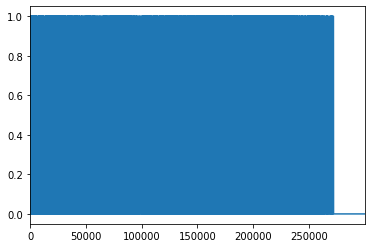

In [38]:
_ = pd.Series(ociosidade_classifier).plot()

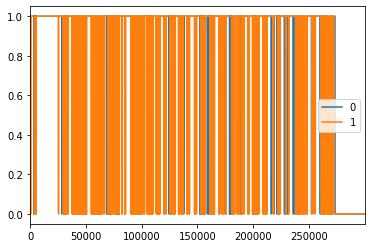

In [39]:
_ = pd.DataFrame(ociosidade_saborizador).plot()

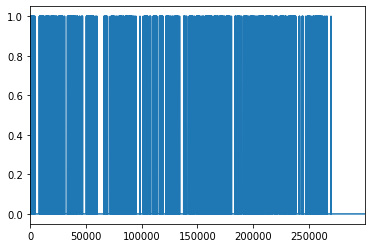

In [40]:
_ = pd.Series(ociosidade_embalador_Box).plot()

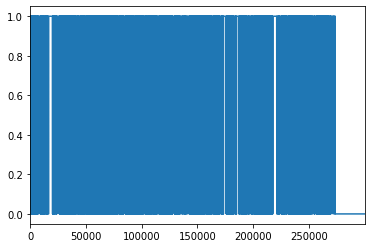

In [41]:
_ = pd.Series(ociosidade_embalador_Bag).plot()

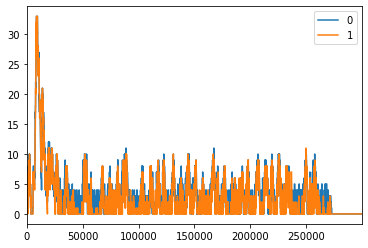

In [42]:
_ = pd.DataFrame(tamanho_da_fila_pfi).plot()

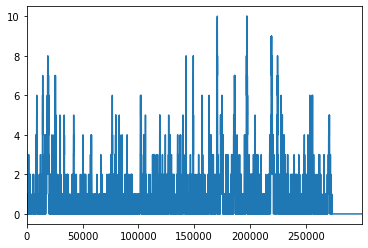

In [43]:
_ = pd.Series(tamanho_da_fila_bag).plot()

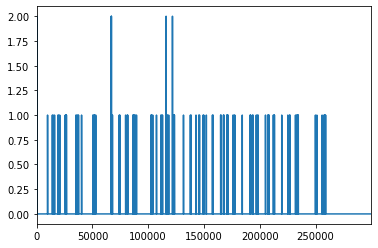

In [44]:
_ = pd.Series(tamanho_da_fila_box).plot()

In [45]:
teste2 = pd.DataFrame(classifier_balance, columns = ['Site', 'Color', 'Qty'])
teste2

,Site,Color,Qty
0,"Detroit, MI",Coloring Agent23,12684.0
1,"Detroit, MI",Coloring Agent23,0.0
2,"Detroit, MI",Coloring Agent23,0.0
3,"Detroit, MI",Coloring Agent23,0.0
4,"Detroit, MI",Coloring Agent23,0.0
...,...,...,...
4551,"Detroit, MI",Coloring Agent17,26850.0
4552,"Detroit, MI",Coloring Agent17,0.0
4553,"Detroit, MI",Coloring Agent17,0.0
4554,"Detroit, MI",Coloring Agent17,0.0


In [76]:
workorder

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim,Dias,Custo
0,"Detroit, MI",DM233286,Coloring Agent23,S1,F1,Bag,1522.0,6,6088.0 bags,0.0,310.000000,0.09,1601.144
1,"Detroit, MI",DM233286,Coloring Agent23,S2,F1,Box,1725.0,6,690.0 boxes,223.0,339.000000,0.03,1720.860
2,"Detroit, MI",DM233286,Coloring Agent23,S2,F11,Box,1505.0,6,602.0 boxes,224.0,376.000000,0.04,1501.388
3,"Detroit, MI",DM233286,Coloring Agent23,S2,F12,Bag,23.0,6,92.0 bags,225.0,311.000000,0.02,24.196
4,"Detroit, MI",DM233286,Coloring Agent23,S3,F1,Box,1550.0,6,620.0 boxes,226.0,457.000000,0.06,1546.280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,"Detroit, MI",NaN,Coloring Agent37,S5,F1,Bag,2677.0,6,10708.0 bags,NaN,253632.115506,NaN,2816.204
4689,"Detroit, MI",DM264799,Coloring Agent26,S2,F10,Bag,1.0,99,,0.0,0.000000,0.00,0.000
4690,"Detroit, MI",NaN,Coloring Agent26,S4,F10,Bag,871.0,6,3484.0 bags,NaN,255728.103941,NaN,916.292
4691,"Detroit, MI",NaN,Coloring Agent21,S4,F12,Bag,42.0,6,168.0 bags,NaN,257077.581778,NaN,44.184


In [68]:
pd.DataFrame(workorder.groupby(['Plant Id','Color','Size','Flavor','Packaging Type']).sum()['Qty']).to_csv(factory+'_Team3234_InventoryBalance.csv',sep=';', decimal = ',')

In [57]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,10000,0,,,0
PFI_Drum2,10000,0,,,1
PFI_Drum3,10000,0,,,2
PFI_Drum4,10000,0,,,3
PFI_Drum5,10000,0,,,4
PFI_Drum6,10000,0,,,5
PFI_Drum7,10000,0,,,6
PFI_Drum8,10000,1452,Coloring Agent4,S3,7
PFI_Drum9,10000,5384,Coloring Agent12,S4,8


In [58]:
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,F9,1,0,273056
PFI_2,F9,1,1,272130


In [59]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,20000,0,,,,0
FI_Drum_2,20000,0,,,,1
FI_Drum_3,20000,0,,,,2
FI_Drum_4,20000,0,,,,3
FI_Drum_5,20000,0,,,,4
FI_Drum_6,20000,0,,,,5
FI_Drum_7,20000,0,,,,6
FI_Drum_8,20000,0,,,,7


In [50]:
#Predizer a falha em uma determinada cor:
#Para cada ordem, determinar o quanto será produzido dos 5 tamanhos, se ela necessitar de tamanho